# The return of Yeti

## Data import

In [1]:
import numpy as np
import pandas as pd
import re
import os
from functools import reduce
import string
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_crm = pd.read_csv('crm_model.csv', parse_dates=['FirstMeeting','LastMeeting'],
                      infer_datetime_format=True)
df_finance = pd.read_csv('finance_model.csv', decimal=',', keep_default_na=False, parse_dates=['Deposit_Date'],
                      infer_datetime_format=True)
df_sales = pd.read_csv('sales_model.csv', parse_dates=['Departure_Date','Return_Date','Early_RPL','Latest_RPL','Initial_System_Date'],
                      infer_datetime_format=True)

In [3]:
df_crm

ID_CRM Poverty_Code               Region  CRM_Segment School_Type  \
0     01000I            0                Other         10.0    Catholic   
1     01001O            0                Other          9.0         CHD   
2     01002G            0                Other          5.0    Catholic   
3     01011Q            0                Other          9.0         CHD   
4     01013I            0               Dallas          1.0         CHD   
...      ...          ...                  ...          ...         ...   
4143   E484O            E                Other          5.0      PUBLIC   
4144  E4961M            E                Other          5.0      PUBLIC   
4145   E533K            E  Northern California          4.0      PUBLIC   
4146   E756O            E                Other          5.0      PUBLIC   
4147   E792Q            E                Other          5.0      PUBLIC   

      Parent_Meeting_Flag MDR_Low_Grade  MDR_High_Grade  \
0                       1            PK             8.0   
1                       1             K            12.0   
2                       1             K             8.0   
3                       1             K            12.0   
4                       1            PK            12.0   
...                   ...           ...             ...   
4143                    1             6             8.0   
4144                    1             6             8.0   
4145                    1             K             6.0   
4146                    1             6             8.0   
4147                    0             6             8.0   

      Total_School_Enrollment Income_Level  SPR_New_Existing  \
0                         403            I                 0   
1                         732            O                 0   
2                         521            G                 1   
3                         437            Q                 0   
4                         226            I                 1   
...                       ...          ...               ...   
4143                      685            O                 0   
4144                      526            M                 1   
4145                      580            K                 0   
4146                      448            O                 0   
4147                      607            Q                 0   

      NumberOfMeetingswithParents FirstMeeting LastMeeting  \
0                               2   2018-05-12  2018-09-19   
1                               1   2018-09-05  2018-09-01   
2                               1   2018-09-09  2018-09-05   
3                               2   2018-05-03  2018-09-04   
4                               2   2018-04-07  2018-08-08   
...                           ...          ...         ...   
4143                            2   2018-04-19  2018-08-24   
4144                            1   2018-09-27  2018-09-19   
4145                            1   2018-09-27  2018-09-16   
4146                            1   2018-10-17  2018-10-28   
4147                            0          NaT         NaT   

      DifferenceTraveltoFirstMeeting  DifferenceTraveltoLastMeeting  \
0                              371.0                          241.0   
1                              150.0                          154.0   
2                              259.0                          263.0   
3                              315.0                          191.0   
4                              418.0                          295.0   
...                              ...                            ...   
4143                           320.0                          193.0   
4144                           195.0                          203.0   
4145                           238.0                          249.0   
4146                           221.0                          210.0   
4147                             NaN                            NaN   

     SchoolGradeTypeLow Schoo

In [4]:
print(df_crm.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4148 entries, 0 to 4147
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID_CRM                          4148 non-null   object        
 1   Poverty_Code                    4148 non-null   object        
 2   Region                          4148 non-null   object        
 3   CRM_Segment                     4144 non-null   float64       
 4   School_Type                     4148 non-null   object        
 5   Parent_Meeting_Flag             4148 non-null   int64         
 6   MDR_Low_Grade                   4148 non-null   object        
 7   MDR_High_Grade                  4032 non-null   float64       
 8   Total_School_Enrollment         4148 non-null   int64         
 9   Income_Level                    4148 non-null   object        
 10  SPR_New_Existing                4148 non-null   int64         
 11  Numb

In [5]:
# check for duplicates in ID_CRM
duplicates_crm = df_crm['ID_CRM'].duplicated()
if duplicates_crm.any():
    print("Found duplicates in ID_CRM column:")
    print(df_crm[duplicates_crm])

In [6]:
df_finance

ID_FINANCE Deposit_Date Special_Pay  Tuition  FRP_Active  FRP_Cancelled  \
0          1389   2018-11-08           0      397           1              1   
1          3090   2019-01-06           0      563           0              0   
2          3639   2018-12-29           0      617           0              0   
3          4249   2018-11-05           0      446           1              1   
4        CP1021   2018-10-20          CP      582          15             11   
...         ...          ...         ...      ...         ...            ...   
4146      SA886   2018-10-04          SA      402           0              0   
4147      SA888   2018-05-30          SA      670           0              0   
4148      SA899   2018-06-07          SA     2151           0              0   
4149      SA939   2018-10-14          SA      414           0              0   
4150      SA959   2018-10-22          SA     1729           0              0   

      FRP_Take_up_percent_  EZ_Pay_Take_Up_Rate  School_Sponsor  \
0                 0.020913             0.017856               1   
1                 0.000000             0.000000               0   
2                 0.000000             0.000000               0   
3                 0.019032             0.019285               1   
4                 0.597237             0.035036               1   
...                    ...                  ...             ...   
4146              0.000000             0.000000               1   
4147              0.000000             0.000000               0   
4148              0.000000             0.000000               0   
4149              0.000000             0.000000               1   
4150              0.000000             0.000000               1   

      SPR_Group_Revenue  FPP_to_PAX  Num_of_Non_FPP_PAX  
0                   447    0.967036                   2  
1                   579    0.993127                   1  
2                   529    0.973946                   1  
3                   381    0.981972                   2  
4                   596    0.963426                   2  
...                 ...         ...                 ...  
4146                378    0.975006                   1  
4147                734    0.910345                   9  
4148               2075    0.839255                   2  
4149                418    0.966618                   2  
4150               1830    0.891704                   5  

[4151 rows x 12 columns]

In [7]:
print(df_finance.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4151 entries, 0 to 4150
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID_FINANCE            4151 non-null   object        
 1   Deposit_Date          4151 non-null   datetime64[ns]
 2   Special_Pay           4151 non-null   object        
 3   Tuition               4151 non-null   int64         
 4   FRP_Active            4151 non-null   int64         
 5   FRP_Cancelled         4151 non-null   int64         
 6   FRP_Take_up_percent_  4151 non-null   float64       
 7   EZ_Pay_Take_Up_Rate   4151 non-null   float64       
 8   School_Sponsor        4151 non-null   int64         
 9   SPR_Group_Revenue     4151 non-null   int64         
 10  FPP_to_PAX            4151 non-null   float64       
 11  Num_of_Non_FPP_PAX    4151 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(2)
memory usage: 389.3+ K

In [8]:
# check for duplicates in ID_FINANCE
duplicates_finance = df_finance['ID_FINANCE'].duplicated()
if duplicates_finance.any():
    print("Found duplicates in ID_FINANCE column:")
    print(df_finance[duplicates_finance])

In [9]:
df_sales

ID_SALES Program_Code  From_Grade  To_Grade Group_State  Days  \
0     CC1387A           CC        10.0      10.0          CA    24   
1      CC139A           CC         5.0       6.0          CA    18   
2     CC1600A           CC         7.0       7.0          OR    13   
3     CC1701A           CC         8.0       8.0          CA    24   
4     CC1773A           CC         7.0       7.0          OR    13   
...       ...          ...         ...       ...         ...   ...   
4148    ST60A           ST         7.0       9.0          WA    18   
4149   ST809A           ST         6.0       8.0          WA    13   
4150   ST925A           ST         8.0      12.0          NJ    20   
4151   ST928A           ST         7.0       8.0          OK    10   
4152   ST960A           ST        10.0      13.0          ND    15   

     Travel_Type Departure_Date Return_Date  Early_RPL  ... SPR_Product_Type  \
0              A     2019-04-07  2019-05-01 2018-05-11  ...       East Coast   
1              A     2019-04-30  2019-05-18 2018-03-05  ...       East Coast   
2              A     2019-03-17  2019-03-30        NaT  ...       East Coast   
3              A     2019-05-08  2019-06-01 2018-02-07  ...       East Coast   
4              A     2019-03-17  2019-03-30        NaT  ...       East Coast   
...          ...            ...         ...        ...  ...              ...   
4148           A     2019-04-04  2019-04-22 2018-03-17  ...          Science   
4149           A     2019-03-21  2019-04-03 2018-03-05  ...          Science   
4150           A     2019-04-16  2019-05-06 2018-01-21  ...          Science   
4151           A     2019-06-01  2019-06-11 2018-03-09  ...          Science   
4152           A     2019-05-29  2019-06-13 2018-03-08  ...          Science   

      FPP  Total_Pax DepartureMonth GroupGradeTypeLow  GroupGradeTypeHigh  \
0      26         29        January                 K                High   
1      21         22        January                PK              Middle   
2       7          7        January                 K              Middle   
3      26         25        January                PK              Middle   
4       7          7        January                 K              Middle   
...   ...        ...            ...               ...                 ...   
4148   12         11        January            Middle                High   
4149   13         17        January        Elementary              Middle   
4150    4          6        January            Middle              Middle   
4151   10         12        January            Middle              Middle   
4152    3          4        January                 K                High   

          GroupGradeType MajorProgramCode FPP_to_School_enrollment Retained  
0                K->High                C        0,126429354314411        1  
1             PK->Middle                C        0,173405156631824        0  
2              K->Middle                C        0,108985714542943        1  
3             PK->Middle                C        0,142807017036153        1  
4              K->Middle                C        0,108985714542943        1  
...                  ...              ...                      ...      ...  
4148        Middle->High                S        0,014665665548888        0  
4149  Elementary->Middle                S         0,01776427530478        1  
4150      Middle->Middle                S        0,006920828413484        0  
4151      Middle->Middle                S        0,009419789252674        1  
4152             K->High                S        0,008308224105284        0  

[4153 rows x 24 columns]

In [10]:
print(df_sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4153 entries, 0 to 4152
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ID_SALES                  4153 non-null   object        
 1   Program_Code              4153 non-null   object        
 2   From_Grade                3927 non-null   float64       
 3   To_Grade                  3884 non-null   float64       
 4   Group_State               4153 non-null   object        
 5   Days                      4153 non-null   int64         
 6   Travel_Type               4153 non-null   object        
 7   Departure_Date            4153 non-null   datetime64[ns]
 8   Return_Date               4153 non-null   datetime64[ns]
 9   Early_RPL                 2985 non-null   datetime64[ns]
 10  Latest_RPL                4116 non-null   datetime64[ns]
 11  Cancelled_Pax             4153 non-null   int64         
 12  Total_Discount_Pax  

In [11]:
# check for duplicates in ID_SALES
duplicates_sales = df_sales['ID_SALES'].duplicated()
if duplicates_sales.any():
    print("Found duplicates in ID_SALES column:")
    print(df_sales[duplicates_sales])

## Merge data

In [12]:
import re

# define a function to remove the last digit and any alphabets in the ID_CRM column
def clean_id_crm(ID_CRM):
    # Remove the last digit
    ID_CRM = ID_CRM[:-1]
    
    # Remove any alphabets
    ID_CRM = re.sub('[^0-9]+', '', ID_CRM)
    
    return ID_CRM

# apply the function to the ID_CRM column
df_crm['ID_CRM'] = df_crm['ID_CRM'].apply(clean_id_crm)

print(df_crm)

     ID_CRM Poverty_Code               Region  CRM_Segment School_Type  \
0     01000            0                Other         10.0    Catholic   
1     01001            0                Other          9.0         CHD   
2     01002            0                Other          5.0    Catholic   
3     01011            0                Other          9.0         CHD   
4     01013            0               Dallas          1.0         CHD   
...     ...          ...                  ...          ...         ...   
4143    484            E                Other          5.0      PUBLIC   
4144   4961            E                Other          5.0      PUBLIC   
4145    533            E  Northern California          4.0      PUBLIC   
4146    756            E                Other          5.0      PUBLIC   
4147    792            E                Other          5.0      PUBLIC   

      Parent_Meeting_Flag MDR_Low_Grade  MDR_High_Grade  \
0                       1            PK             

In [13]:
# define a function to remove alphabets from the 'ID_FINANCE' column
def remove_alpha(s):
    return ''.join([i for i in s if not i.isalpha()])

# apply the function to the id_finance column
df_finance['ID_FINANCE'] = df_finance['ID_FINANCE'].apply(remove_alpha)

print(df_finance)

     ID_FINANCE Deposit_Date Special_Pay  Tuition  FRP_Active  FRP_Cancelled  \
0          1389   2018-11-08           0      397           1              1   
1          3090   2019-01-06           0      563           0              0   
2          3639   2018-12-29           0      617           0              0   
3          4249   2018-11-05           0      446           1              1   
4          1021   2018-10-20          CP      582          15             11   
...         ...          ...         ...      ...         ...            ...   
4146        886   2018-10-04          SA      402           0              0   
4147        888   2018-05-30          SA      670           0              0   
4148        899   2018-06-07          SA     2151           0              0   
4149        939   2018-10-14          SA      414           0              0   
4150        959   2018-10-22          SA     1729           0              0   

      FRP_Take_up_percent_  EZ_Pay_Take

In [14]:
# define a function to remove alphabets and 0 from the 'ID_SALES' column

def remove_alpha(s):
    s = ''.join([i for i in s if not i.isalpha()])
    if len(s) > 4 and s[-1] == '0':
        s = s[:-1]
    return s

# apply the function to the 'ID_SALES' column
df_sales['ID_SALES'] = df_sales['ID_SALES'].apply(remove_alpha)

print(df_sales)

     ID_SALES Program_Code  From_Grade  To_Grade Group_State  Days  \
0        1387           CC        10.0      10.0          CA    24   
1         139           CC         5.0       6.0          CA    18   
2        1600           CC         7.0       7.0          OR    13   
3        1701           CC         8.0       8.0          CA    24   
4        1773           CC         7.0       7.0          OR    13   
...       ...          ...         ...       ...         ...   ...   
4148       60           ST         7.0       9.0          WA    18   
4149      809           ST         6.0       8.0          WA    13   
4150      925           ST         8.0      12.0          NJ    20   
4151      928           ST         7.0       8.0          OK    10   
4152      960           ST        10.0      13.0          ND    15   

     Travel_Type Departure_Date Return_Date  Early_RPL  ... SPR_Product_Type  \
0              A     2019-04-07  2019-05-01 2018-05-11  ...       East Coast   

In [15]:
# check data type of ID columns
print(df_crm['ID_CRM'].dtype)
print(df_finance['ID_FINANCE'].dtype)
print(df_sales['ID_SALES'].dtype)

object
object
object


In [16]:
# change data type to integer for merging
df_crm['ID_CRM'] = df_crm['ID_CRM'].astype(int)
df_finance['ID_FINANCE'] = df_finance['ID_FINANCE'].astype(int)
df_sales['ID_SALES'] = df_sales['ID_SALES'].astype(int)

In [17]:
# recheck data type of ID columns
print(df_crm['ID_CRM'].dtype)
print(df_finance['ID_FINANCE'].dtype)
print(df_sales['ID_SALES'].dtype)

int64
int64
int64


In [18]:
# Rename the ID columns to a common name
df_crm = df_crm.rename(columns={'ID_CRM': 'ID'})
df_finance = df_finance.rename(columns={'ID_FINANCE': 'ID'})
df_sales = df_sales.rename(columns={'ID_SALES': 'ID'})

# Merge the dataframes on the common ID column
df_model = pd.merge(df_crm, df_finance, on='ID', how='outer')
df_model = pd.merge(df_model, df_sales, on='ID', how='outer')

# Display the merged dataframe
print(df_model.head())

     ID Poverty_Code  Region  CRM_Segment School_Type  Parent_Meeting_Flag  \
0  1000            0   Other         10.0    Catholic                  1.0   
1  1001            0   Other          9.0         CHD                  1.0   
2  1002            0   Other          5.0    Catholic                  1.0   
3  1011            0   Other          9.0         CHD                  1.0   
4  1013            0  Dallas          1.0         CHD                  1.0   

  MDR_Low_Grade  MDR_High_Grade  Total_School_Enrollment Income_Level  ...  \
0            PK             8.0                    403.0            I  ...   
1             K            12.0                    732.0            O  ...   
2             K             8.0                    521.0            G  ...   
3             K            12.0                    437.0            Q  ...   
4            PK            12.0                    226.0            I  ...   

   SPR_Product_Type   FPP Total_Pax DepartureMonth  GroupGrade

In [19]:
# check for duplicates in ID
duplicates_model = df_model['ID'].duplicated()
if duplicates_model.any():
    print("Found duplicates in ID column:")
    print(df_model[duplicates_model])

In [20]:
print(df_model.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4156 entries, 0 to 4155
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID                              4156 non-null   int64         
 1   Poverty_Code                    4148 non-null   object        
 2   Region                          4148 non-null   object        
 3   CRM_Segment                     4144 non-null   float64       
 4   School_Type                     4148 non-null   object        
 5   Parent_Meeting_Flag             4148 non-null   float64       
 6   MDR_Low_Grade                   4148 non-null   object        
 7   MDR_High_Grade                  4032 non-null   float64       
 8   Total_School_Enrollment         4148 non-null   float64       
 9   Income_Level                    4148 non-null   object        
 10  SPR_New_Existing                4148 non-null   float64       
 11  Numb

## Cleaning data

In [21]:
# Remove rows without labels/ID without target
df_model = df_model[df_model['Retained'].notna()]

In [22]:
# Check for NULL values
null_values = df_model.isnull().sum()

# Print the null values for each column
print(null_values)

ID                                   0
Poverty_Code                         5
Region                               5
CRM_Segment                          9
School_Type                          5
Parent_Meeting_Flag                  5
MDR_Low_Grade                        5
MDR_High_Grade                     121
Total_School_Enrollment              5
Income_Level                         5
SPR_New_Existing                     5
NumberOfMeetingswithParents          5
FirstMeeting                       601
LastMeeting                        601
DifferenceTraveltoFirstMeeting     601
DifferenceTraveltoLastMeeting      601
SchoolGradeTypeLow                   5
SchoolGradeTypeHigh                  5
SchoolGradeType                      5
SchoolSizeIndicator                164
Deposit_Date                         5
Special_Pay                          5
Tuition                              5
FRP_Active                           5
FRP_Cancelled                        5
FRP_Take_up_percent_     

In [23]:
# Remove 5 Null rows across columns
df_model = df_model[df_model['Poverty_Code'].notna()]

In [24]:
# Change data type
df_model['ID'] = df_model['ID'].astype('string')
df_model['Region'] = df_model['Region'].astype('string')
df_model['CRM_Segment'] = df_model['CRM_Segment'].astype('object')
df_model['MDR_High_Grade'] = df_model['MDR_High_Grade'].astype('object')
df_model['School_Type'] = df_model['School_Type'].astype('string')
df_model['Parent_Meeting_Flag'] = df_model['Parent_Meeting_Flag'].astype(str)
df_model['Income_Level'] = df_model['Income_Level'].astype('string')
df_model['SPR_New_Existing'] = df_model['SPR_New_Existing'].astype(str)
df_model['SchoolGradeTypeLow'] = df_model['SchoolGradeTypeLow'].astype('string')
df_model['SchoolGradeTypeHigh'] = df_model['SchoolGradeTypeHigh'].astype('string')
df_model['SchoolGradeType'] = df_model['SchoolGradeType'].astype('string')
df_model['SchoolSizeIndicator'] = df_model['SchoolSizeIndicator'].astype(str)
df_model['School_Sponsor'] = df_model['School_Sponsor'].astype(str)
df_model['Program_Code'] = df_model['Program_Code'].astype('string')
df_model['From_Grade'] = df_model['From_Grade'].astype('string')
df_model['To_Grade'] = df_model['To_Grade'].astype('string')
df_model['Group_State'] = df_model['Group_State'].astype('string')
df_model['Travel_Type'] = df_model['Travel_Type'].astype('string')
df_model['SPR_Product_Type'] = df_model['SPR_Product_Type'].astype('string')
df_model['GroupGradeTypeLow'] = df_model['GroupGradeTypeLow'].astype('string')
df_model['GroupGradeTypeHigh'] = df_model['GroupGradeTypeHigh'].astype('string')
df_model['MajorProgramCode'] = df_model['MajorProgramCode'].astype('string')
df_model['Retained'] = df_model['Retained'].astype(bool)

In [25]:
# Extract the day, month, and year components of each date column

for col in ['FirstMeeting', 'LastMeeting','Deposit_Date','Departure_Date','Return_Date','Latest_RPL','Early_RPL','Initial_System_Date']:
    df_model[f'{col}_date'] = df_model[col].dt.strftime('%d')
    df_model[f'{col}_month'] = df_model[col].dt.strftime('%B')
    df_model[f'{col}_year'] = df_model[col].dt.strftime('%Y')

# Drop DepartureMonth to avoid duplicate
df_model=df_model.drop('DepartureMonth', axis=1) 

In [26]:
print(df_model.head())

     ID Poverty_Code  Region CRM_Segment School_Type Parent_Meeting_Flag  \
0  1000            0   Other        10.0    Catholic                 1.0   
1  1001            0   Other         9.0         CHD                 1.0   
2  1002            0   Other         5.0    Catholic                 1.0   
3  1011            0   Other         9.0         CHD                 1.0   
4  1013            0  Dallas         1.0         CHD                 1.0   

  MDR_Low_Grade MDR_High_Grade  Total_School_Enrollment Income_Level  ...  \
0            PK            8.0                    403.0            I  ...   
1             K           12.0                    732.0            O  ...   
2             K            8.0                    521.0            G  ...   
3             K           12.0                    437.0            Q  ...   
4            PK           12.0                    226.0            I  ...   

  Return_Date_year  Latest_RPL_date Latest_RPL_month Latest_RPL_year  \
0       

In [27]:
# Replace Null in Date features as 0/0/2000
fill_values = {'FirstMeeting_date': '0', 'FirstMeeting_month': '0',
               'FirstMeeting_year': '2000','LastMeeting_date': '0','LastMeeting_month': '0','LastMeeting_year': '2000',
               'Early_RPL_date':'0','Early_RPL_month':'0','Early_RPL_year':'2000','Latest_RPL_date': '0',
               'Latest_RPL_month': '0','Latest_RPL_year': '2000',
               'Initial_System_Date_date':'0','Initial_System_Date_month':'0','Initial_System_Date_year':'2000'}

df_model = df_model.fillna(value=fill_values)

In [28]:
# Check for NULL values
null_values = df_model.isnull().sum()

# Print the null values for each column
print(null_values)

ID                           0
Poverty_Code                 0
Region                       0
CRM_Segment                  4
School_Type                  0
                            ..
Early_RPL_month              0
Early_RPL_year               0
Initial_System_Date_date     0
Initial_System_Date_month    0
Initial_System_Date_year     0
Length: 77, dtype: int64


In [29]:
# Remove negative value on DifferenceTraveltoLastMeeting
    # According to well-defined structure, the meeting should occur before the Departure date
df_model.drop(df_model[df_model['DifferenceTraveltoLastMeeting'] < 0].index, inplace=True)

# Fill in DifferenceTraveltoFirstMeeting & DifferenceTraveltoLastMeeting as 0 as the meeting did not occur
df_model['DifferenceTraveltoFirstMeeting'].fillna(0, inplace=True)
df_model['DifferenceTraveltoLastMeeting'].fillna(0, inplace=True)

# Check for NULL values
null_values_diff = df_model['DifferenceTraveltoLastMeeting'].isnull().sum()

# Print the null values for each column
print(null_values_diff)

0


In [30]:
# Drop and Recalculate FRP_Take_up_percent_ for accuracy
df_model=df_model.drop('FRP_Take_up_percent_', axis=1)

df_model['FRP_Take_up_percent']=(df_model['FRP_Active']-df_model['FRP_Cancelled']).div(df_model['FPP'])
print(df_model['FRP_Take_up_percent'].head())

0    0.160000
1    0.494624
2    0.607143
3    0.444444
4    0.714286
Name: FRP_Take_up_percent, dtype: float64


In [31]:
# Drop and Recalculate FPP_to_PAX for accuracy
df_model=df_model.drop('FPP_to_PAX', axis=1)

df_model['FPP_to_PAX']=df_model['FPP'].div(df_model['Total_Pax'])
print(df_model['FPP_to_PAX'].head())

0    1.041667
1    1.068966
2    1.120000
3    0.900000
4    1.076923
Name: FPP_to_PAX, dtype: float64


In [32]:
# Drop and Recalculate FPP_to_School_enrollment for accuracy
df_model=df_model.drop('FPP_to_School_enrollment', axis=1)

df_model['FPP_to_School_enrollment']=df_model['FPP'].div(df_model['Total_School_Enrollment'])
print(df_model['FPP_to_School_enrollment'].head())

0    0.062035
1    0.127049
2    0.107486
3    0.020595
4    0.061947
Name: FPP_to_School_enrollment, dtype: float64


In [33]:
df_model['FPP_to_School_enrollment'].describe()

count    4142.000000
mean             inf
std              NaN
min         0.000984
25%         0.021386
50%         0.047843
75%         0.095372
max              inf
Name: FPP_to_School_enrollment, dtype: float64

In [34]:
# Replace infinite values with 1 in the 'FPP_to_School_enrollment' column
df_model['FPP_to_School_enrollment'] = df_model['FPP_to_School_enrollment'].replace([np.inf, -np.inf], 1)

In [35]:
# Verify change
df_model['FPP_to_School_enrollment'].describe()

count    4142.000000
mean        0.102363
std         0.196378
min         0.000984
25%         0.021386
50%         0.047843
75%         0.095372
max         1.782609
Name: FPP_to_School_enrollment, dtype: float64

In [36]:
# Replace From_Grade, To_Grade with 0 to recognize as NA
df_model['From_Grade'].fillna('0', inplace=True)
df_model['To_Grade'].fillna('0', inplace=True)

In [37]:
# Verify Null
null_values = df_model.isnull().sum()
print(null_values)

ID                           0
Poverty_Code                 0
Region                       0
CRM_Segment                  4
School_Type                  0
                            ..
Initial_System_Date_month    0
Initial_System_Date_year     0
FRP_Take_up_percent          0
FPP_to_PAX                   0
FPP_to_School_enrollment     0
Length: 77, dtype: int64


In [38]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4142 entries, 0 to 4147
Data columns (total 77 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID                              4142 non-null   string        
 1   Poverty_Code                    4142 non-null   object        
 2   Region                          4142 non-null   string        
 3   CRM_Segment                     4138 non-null   object        
 4   School_Type                     4142 non-null   string        
 5   Parent_Meeting_Flag             4142 non-null   object        
 6   MDR_Low_Grade                   4142 non-null   object        
 7   MDR_High_Grade                  4027 non-null   object        
 8   Total_School_Enrollment         4142 non-null   float64       
 9   Income_Level                    4142 non-null   string        
 10  SPR_New_Existing                4142 non-null   object        
 11  Numb

## Exploratory Analysis

In [39]:
#df_model.to_csv('Merged.csv', index=False)

In [40]:
df_model.describe()

Total_School_Enrollment  NumberOfMeetingswithParents  \
count              4142.000000                  4142.000000   
mean                623.314341                     1.098503   
std                 422.624451                     0.613738   
min                   0.000000                     0.000000   
25%                 336.000000                     1.000000   
50%                 571.000000                     1.000000   
75%                 821.000000                     1.000000   
max                4005.000000                     2.000000   

       DifferenceTraveltoFirstMeeting  DifferenceTraveltoLastMeeting  \
count                     4142.000000                    4142.000000   
mean                       224.769194                     196.350314   
std                        117.542776                      93.676573   
min                          0.000000                       0.000000   
25%                        185.000000                     178.000000   
50%                        237.000000                     220.000000   
75%                        278.000000                     257.000000   
max                        752.000000                     759.000000   

           Tuition   FRP_Active  FRP_Cancelled  EZ_Pay_Take_Up_Rate  \
count  4142.000000  4142.000000    4142.000000          4142.000000   
mean   1616.726944    16.884114       3.345244             0.208830   
std     660.257949    17.191300       3.745344             0.160837   
min      72.000000     0.000000       0.000000             0.000000   
25%    1163.000000     6.000000       1.000000             0.100089   
50%    1710.000000    12.000000       2.000000             0.190833   
75%    2067.000000    23.000000       5.000000             0.294707   
max    4352.000000   269.000000      45.000000             1.970037   

       SPR_Group_Revenue  Num_of_Non_FPP_PAX         Days  Cancelled_Pax  \
count        4142.000000         4142.000000  4142.000000    4142.000000   
mean         1612.324722            2.967407    15.207871       4.837277   
std           654.298840            2.956115     6.655711       4.703021   
min            73.000000            0.000000     1.000000       0.000000   
25%          1158.250000            1.000000    11.000000       2.000000   
50%          1707.000000            2.000000    15.000000       4.000000   
75%          2061.000000            4.000000    19.000000       7.000000   
max          4610.000000           50.000000    52.000000      44.000000   

       Total_Discount_Pax          FPP    Total_Pax  FRP_Take_up_percent  \
count         4142.000000  4142.000000  4142.000000          4142.000000   
mean             2.960647    31.375423    34.450024             0.402583   
std              2.979224    29.573460    32.083014             0.329124   
min              0.000000     2.000000     2.000000            -2.750000   
25%              1.000000    12.000000    14.000000             0.259259   
50%              2.000000    23.000000    26.000000             0.454545   
75%              4.000000    41.000000    45.000000             0.600000   
max             53.000000   296.000000   320.000000             1.500000   

        FPP_to_PAX  FPP_to_School_enrollment  
count  4142.000000               4142.000000  
mean      0.902080                  0.102363  
std       0.130076                  0.196378  
min       0.500000                  0.000984  
25%       0.800000                  0.021386  
50%       0.900000                  0.047843  
75%       1.000000                  0.095372  
max       1.294118                  1.782609

In [41]:
df_model.shape

(4142, 77)

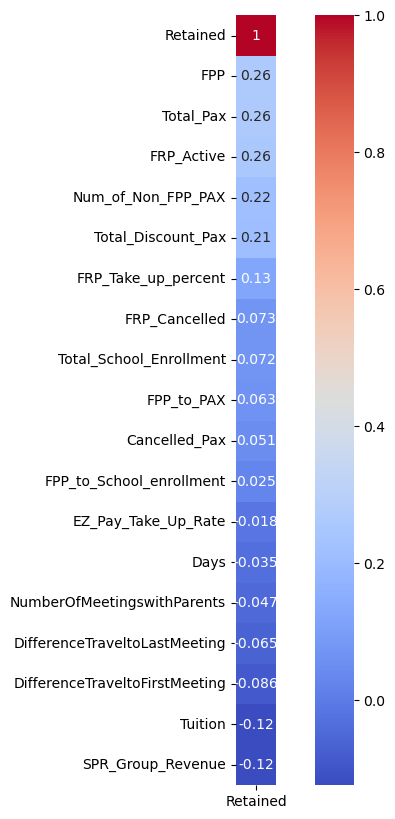

In [42]:
# Correlation between target and other features
import seaborn as sns
import matplotlib.pyplot as plt

# Get the correlation matrix 
corr_matrix = df_model.corr() #between all features
corr_target = corr_matrix['Retained'] #between the target column and all other features

# Convert the correlation to a dataframe and rank
corr_target_df = pd.DataFrame(corr_target)
corr_target_sorted = corr_target_df.sort_values(by='Retained', ascending=False)

# Plot the correlation heatmap
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_target_sorted, annot=True, square=True, cmap='coolwarm', ax=ax)
plt.yticks(rotation=360)
plt.show()

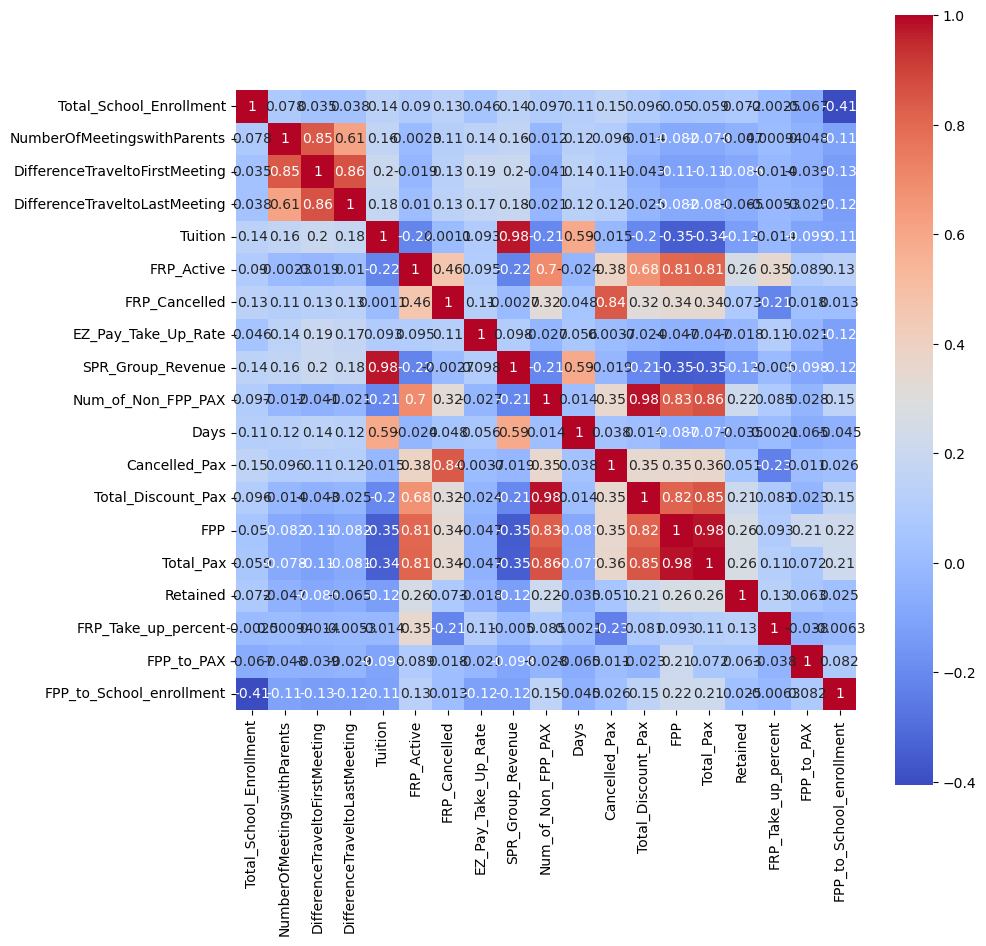

In [43]:
# Correlation between features
import seaborn as sns
import matplotlib.pyplot as plt

# Get the correlation matrix 
corr_mat = df_model.corr() #between all features

# Plot the correlation heatmap
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_mat, annot=True, square=True, cmap='coolwarm', ax=ax)
plt.yticks(rotation=360)
plt.show()

#### Highly correlated features
- Total_Pax & FPP
- Total_Discount_Pax & Num_of_Non_FPP_PAX
- SPR_Group_Revenue & Tuition
- Total_Pax & Num_of_Non_FPP_PAX
- DifferenceTraveltoFirstMeeting & DifferenceTraveltoLastMeeting

## Split Train/Test sets

In [44]:
X=df_model.drop('Retained', axis=1) #select data except Retained
y=df_model['Retained']

In [45]:
y.head()

0     True
1     True
2    False
3    False
4     True
Name: Retained, dtype: bool

In [46]:
from sklearn.model_selection import train_test_split

#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.30,
                                                    stratify=y, #preserve target propotions 
                                                    random_state= 321) #fix random seed for replicability

print(X_train.shape, X_test.shape)

(2899, 76) (1243, 76)


### Split categorical/numerical variables

In [47]:
X_train.dtypes

ID                            string
Poverty_Code                  object
Region                        string
CRM_Segment                   object
School_Type                   string
                              ...   
Initial_System_Date_month     object
Initial_System_Date_year      object
FRP_Take_up_percent          float64
FPP_to_PAX                   float64
FPP_to_School_enrollment     float64
Length: 76, dtype: object

In [48]:
# Select Categorical data for the training dataset
X_train_cat=X_train.select_dtypes(include=['string','object','category'])
X_test_cat=X_test.select_dtypes(include=['string','object','category'])

X_train_cat.head()

ID Poverty_Code   Region CRM_Segment School_Type Parent_Meeting_Flag  \
2382  3372            B    Other        10.0      PUBLIC                 1.0   
1826  1827            B    Other         9.0      PUBLIC                 1.0   
4065  1816            D  Houston         1.0      PUBLIC                 1.0   
2877  4743            B    Other         5.0      PUBLIC                 1.0   
2241  2982            B    Other        10.0      PUBLIC                 1.0   

     MDR_Low_Grade MDR_High_Grade Income_Level SPR_New_Existing  ...  \
2382             6           12.0            J              0.0  ...   
1826             6            8.0            J              1.0  ...   
4065             7            8.0            B              1.0  ...   
2877             9           12.0            O              1.0  ...   
2241             6            8.0            O              0.0  ...   

     Return_Date_year Latest_RPL_date Latest_RPL_month Latest_RPL_year  \
2382             2019              16           August            2018   
1826             2019              04           August            2018   
4065             2019              26        September            2018   
2877             2019              18           August            2018   
2241             2019              18        September            2018   

     Early_RPL_date Early_RPL_month Early_RPL_year Initial_System_Date_date  \
2382             28           April           2018                       02   
1826             12           March           2018                       22   
4065             12           March           2018                       25   
2877             13           March           2018                       04   
2241              0               0           2000                       15   

     Initial_System_Date_month Initial_System_Date_year  
2382                       May                     2018  
1826                     March                     2018  
4065                   October                     2017  
2877                     April                     2018  
2241                    August                     2018  

[5 rows x 50 columns]

In [49]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2899 entries, 2382 to 2977
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         2899 non-null   string
 1   Poverty_Code               2899 non-null   object
 2   Region                     2899 non-null   string
 3   CRM_Segment                2895 non-null   object
 4   School_Type                2899 non-null   string
 5   Parent_Meeting_Flag        2899 non-null   object
 6   MDR_Low_Grade              2899 non-null   object
 7   MDR_High_Grade             2812 non-null   object
 8   Income_Level               2899 non-null   string
 9   SPR_New_Existing           2899 non-null   object
 10  SchoolGradeTypeLow         2899 non-null   string
 11  SchoolGradeTypeHigh        2899 non-null   string
 12  SchoolGradeType            2899 non-null   string
 13  SchoolSizeIndicator        2899 non-null   object
 14  Speci

In [50]:
# Select Numerical data for the training dataset
import numpy as np

X_train_num=X_train.select_dtypes(include=[np.number])
X_test_num=X_test.select_dtypes(include=[np.number])

X_train_num.head()

Total_School_Enrollment  NumberOfMeetingswithParents  \
2382                    255.0                          2.0   
1826                    227.0                          1.0   
4065                    443.0                          1.0   
2877                   1381.0                          2.0   
2241                    560.0                          1.0   

      DifferenceTraveltoFirstMeeting  DifferenceTraveltoLastMeeting  Tuition  \
2382                           385.0                          239.0   1445.0   
1826                           262.0                          279.0   1661.0   
4065                           266.0                          267.0   1686.0   
2877                           314.0                          201.0   2589.0   
2241                           235.0                          219.0   1905.0   

      FRP_Active  FRP_Cancelled  EZ_Pay_Take_Up_Rate  SPR_Group_Revenue  \
2382         9.0            0.0             0.477843             1365.0   
1826        25.0            3.0             0.296457             1535.0   
4065         6.0            4.0             0.331743             1868.0   
2877        14.0            7.0             0.236866             2505.0   
2241        23.0            3.0             0.203967             1970.0   

      Num_of_Non_FPP_PAX  Days  Cancelled_Pax  Total_Discount_Pax   FPP  \
2382                 1.0  16.0            2.0                 1.0   9.0   
1826                 3.0   9.0            5.0                 3.0  41.0   
4065                 1.0  19.0           10.0                 1.0  10.0   
2877                 2.0  18.0            8.0                 2.0  16.0   
2241                 4.0   9.0            3.0                 4.0  46.0   

      Total_Pax  FRP_Take_up_percent  FPP_to_PAX  FPP_to_School_enrollment  
2382       11.0             1.000000    0.818182                  0.035294  
1826       50.0             0.536585    0.820000                  0.180617  
4065       11.0             0.200000    0.909091                  0.022573  
2877       20.0             0.437500    0.800000                  0.011586  
2241       51.0             0.434783    0.901961                  0.082143

### Categorical data

In [51]:
print(X_train_cat.shape)
print(X_test_cat.shape)

(2899, 50)
(1243, 50)


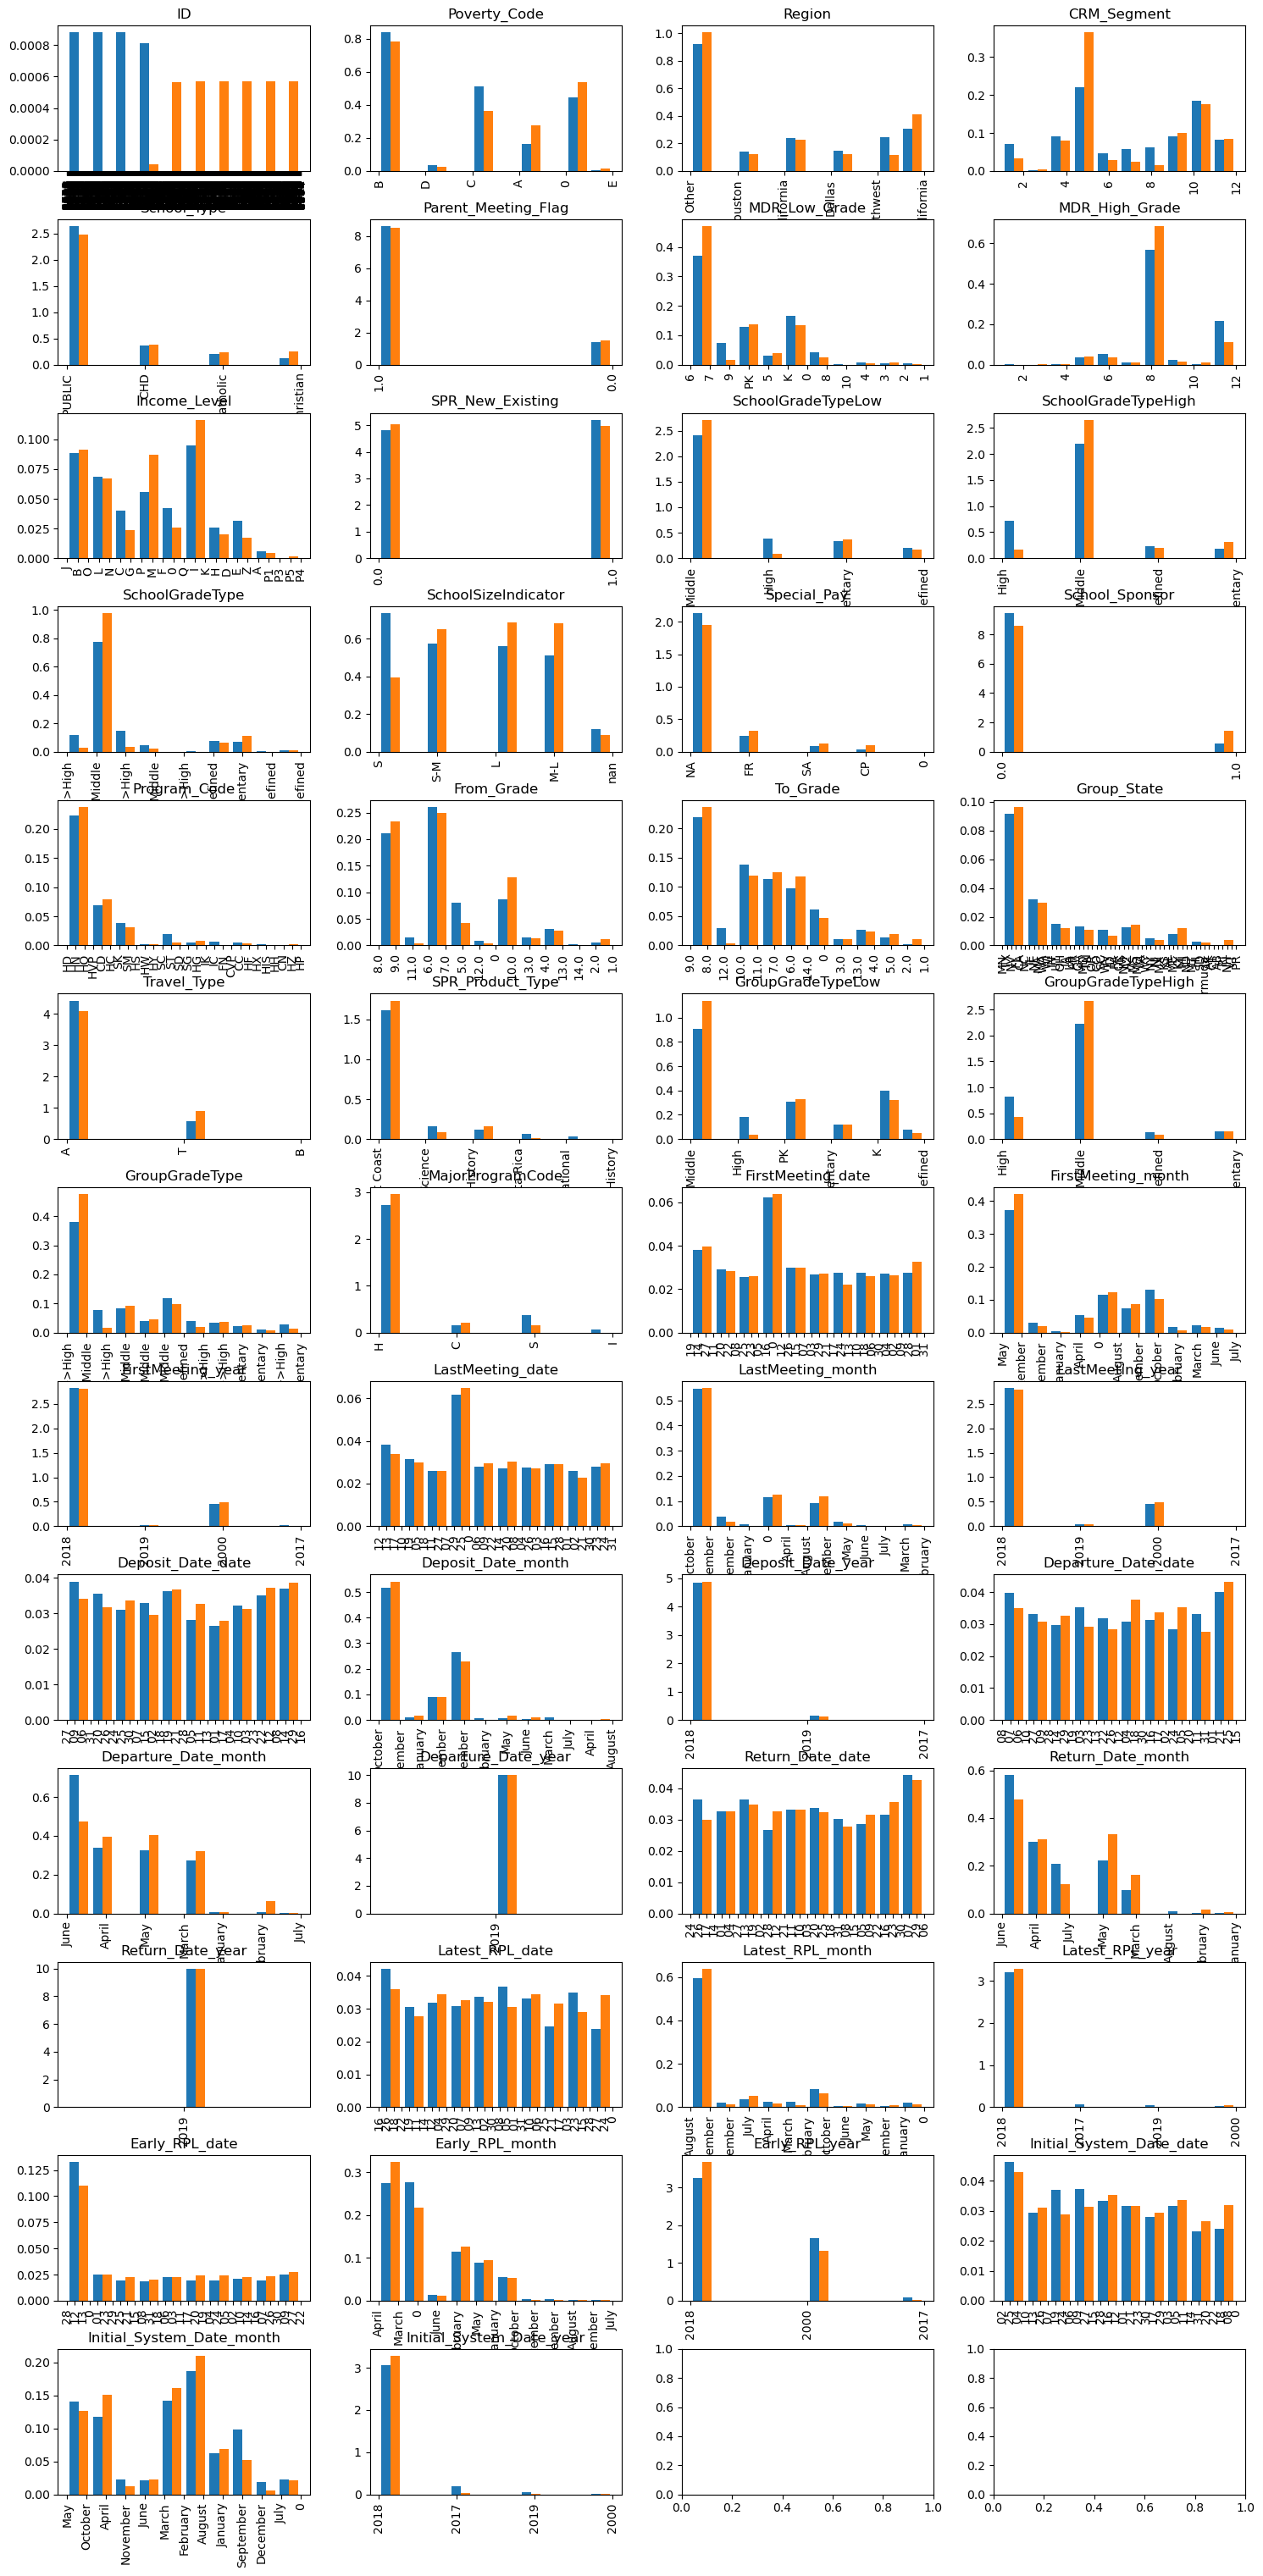

In [52]:
# Histogram for Categorical data
import matplotlib.pyplot as plt

df_0=X_train_cat[y_train==0] # records wih target==0
df_1=X_train_cat[y_train==1] # records wih target==1

fig, axes = plt.subplots(13, 4,figsize=[15,30])
axes = axes.flatten()
fig.tight_layout(pad=2)

i=0
for x in X_train_cat.columns: 
    plt.sca(axes[i]) 
    plt.hist([df_0[x],df_1[x]],density=True) #normalize
    plt.title(x)
    plt.xticks(rotation=90, ha='center')
    i+=1
plt.show()

In [53]:
# Selection for categorical variables
from sklearn.preprocessing import OneHotEncoder
selection_cat=['Poverty_Code','Region', 'CRM_Segment', 'School_Type','Income_Level', 'SPR_New_Existing',
               'SchoolGradeType', 'SchoolSizeIndicator', 'Special_Pay', 'School_Sponsor','Program_Code',
               'From_Grade','To_Grade','Group_State','Travel_Type','SPR_Product_Type','GroupGradeType','MajorProgramCode',
               'FirstMeeting_month','Departure_Date_month','Latest_RPL_month','Early_RPL_month'] #22
    # Reminder: 0/0/2000 for Early_RPL & FirstMeeting & LastMeeting

# Encode the categorical variables by creating dummy
encoder = OneHotEncoder(handle_unknown='ignore') #encode with training data
encoder.fit(X_train_cat[selection_cat])

OneHotEncoder(handle_unknown='ignore')

In [54]:
encoder.categories_

[array(['0', 'A', 'B', 'C', 'D', 'E'], dtype=object),
 array(['Dallas', 'Houston', 'Northern California', 'Other',
        'Pacific Northwest', 'Southern California'], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, nan],
       dtype=object),
 array(['CHD', 'Catholic', 'PUBLIC', 'Private non-Christian'], dtype=object),
 array(['0', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
        'M', 'N', 'O', 'P', 'P1', 'P3', 'P4', 'P5', 'Q', 'Z'], dtype=object),
 array(['0.0', '1.0'], dtype=object),
 array(['Elementary->Elementary', 'Elementary->High', 'Elementary->Middle',
        'Elementary->Undefined', 'High->High', 'Middle->High',
        'Middle->Middle', 'Middle->Undefined', 'Undefined->Undefined'],
       dtype=object),
 array(['L', 'M-L', 'S', 'S-M', 'nan'], dtype=object),
 array(['0', 'CP', 'FR', 'NA', 'SA'], dtype=object),
 array(['0.0', '1.0'], dtype=object),
 array(['CC', 'CD', 'CN', 'CVP', 'FN', 'HC', 'HD', 'HF', 'HG', 'HH', 'HI

In [55]:
columns_dummies=encoder.get_feature_names_out()
columns_dummies

array(['Poverty_Code_0', 'Poverty_Code_A', 'Poverty_Code_B',
       'Poverty_Code_C', 'Poverty_Code_D', 'Poverty_Code_E',
       'Region_Dallas', 'Region_Houston', 'Region_Northern California',
       'Region_Other', 'Region_Pacific Northwest',
       'Region_Southern California', 'CRM_Segment_1.0', 'CRM_Segment_2.0',
       'CRM_Segment_3.0', 'CRM_Segment_4.0', 'CRM_Segment_5.0',
       'CRM_Segment_6.0', 'CRM_Segment_7.0', 'CRM_Segment_8.0',
       'CRM_Segment_9.0', 'CRM_Segment_10.0', 'CRM_Segment_11.0',
       'CRM_Segment_12.0', 'CRM_Segment_nan', 'School_Type_CHD',
       'School_Type_Catholic', 'School_Type_PUBLIC',
       'School_Type_Private non-Christian', 'Income_Level_0',
       'Income_Level_A', 'Income_Level_B', 'Income_Level_C',
       'Income_Level_D', 'Income_Level_E', 'Income_Level_F',
       'Income_Level_G', 'Income_Level_H', 'Income_Level_I',
       'Income_Level_J', 'Income_Level_K', 'Income_Level_L',
       'Income_Level_M', 'Income_Level_N', 'Income_Level_O',
 

In [56]:
# Create dummies

#1st using encoder on training dataset
dummies_train = encoder.transform(X_train_cat[selection_cat]).toarray()
#2nd the same encoder on the same test dataset
dummies_test = encoder.transform(X_test_cat[selection_cat]).toarray()

dummies_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [57]:
dummies_train=pd.DataFrame(dummies_train,columns=columns_dummies)
dummies_test=pd.DataFrame(dummies_test,columns=columns_dummies)

In [58]:
dummies_train.shape

(2899, 258)

In [59]:
# Save the scaler(encoder)
import pickle
pickle.dump(encoder, open('encoder.pkl', 'wb'))

### Numerical data

In [60]:
# Check Null values
null_num = np.sum(np.isinf(X_train_num))

print(null_num)

Total_School_Enrollment           0
NumberOfMeetingswithParents       0
DifferenceTraveltoFirstMeeting    0
DifferenceTraveltoLastMeeting     0
Tuition                           0
FRP_Active                        0
FRP_Cancelled                     0
EZ_Pay_Take_Up_Rate               0
SPR_Group_Revenue                 0
Num_of_Non_FPP_PAX                0
Days                              0
Cancelled_Pax                     0
Total_Discount_Pax                0
FPP                               0
Total_Pax                         0
FRP_Take_up_percent               0
FPP_to_PAX                        0
FPP_to_School_enrollment          0
dtype: int64


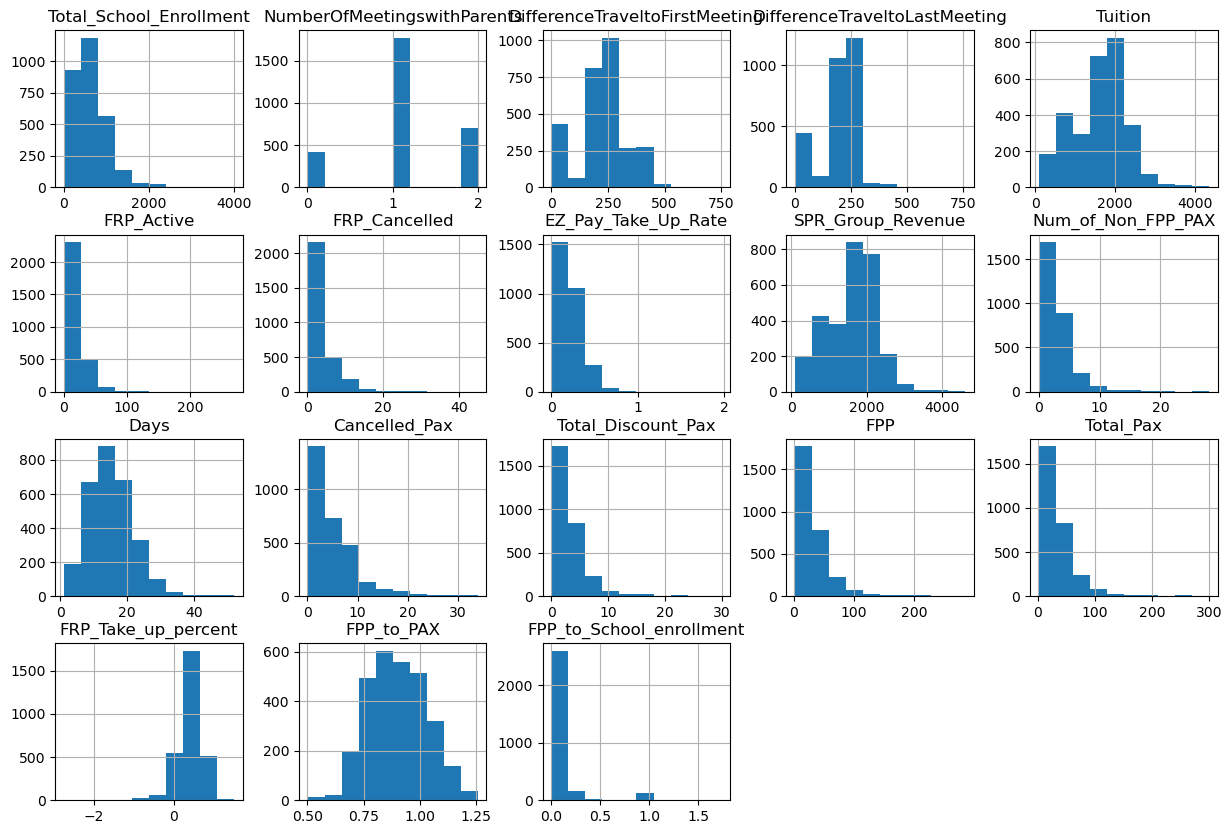

In [61]:
#See how data distributed
df_hist=X_train_num.hist(layout=(4,5), figsize=(15,10))

In [62]:
import math
pd.options.mode.chained_assignment = None

# Create log variables on skewed features (Train)
X_train_num['logTotal_School_Enrollment']=X_train_num['Total_School_Enrollment'].apply(lambda x: math.log(x+1))
X_train_num['logFRP_Active']=X_train_num['FRP_Active'].apply(lambda x: math.log(x+1))
X_train_num['logFRP_Cancelled']=X_train_num['FRP_Cancelled'].apply(lambda x: math.log(x+1))
X_train_num['logEZ_Pay_Take_Up_Rate']=X_train_num['EZ_Pay_Take_Up_Rate'].apply(lambda x: math.log(x+1))
X_train_num['logNum_of_Non_FPP_PAX']=X_train_num['Num_of_Non_FPP_PAX'].apply(lambda x: math.log(x+1))
X_train_num['logCancelled_Pax']=X_train_num['Cancelled_Pax'].apply(lambda x: math.log(x+1))
X_train_num['logTotal_Discount_Pax']=X_train_num['Total_Discount_Pax'].apply(lambda x: math.log(x+1))
X_train_num['logFPP']=X_train_num['FPP'].apply(lambda x: math.log(x+1))
X_train_num['logTotal_Pax']=X_train_num['Total_Pax'].apply(lambda x: math.log(x+1))
X_train_num['logFPP_to_School_enrollment']=X_train_num['FPP_to_School_enrollment'].apply(lambda x: math.log(x+1))


In [63]:
X_train_num.head(3)

Total_School_Enrollment  NumberOfMeetingswithParents  \
2382                    255.0                          2.0   
1826                    227.0                          1.0   
4065                    443.0                          1.0   

      DifferenceTraveltoFirstMeeting  DifferenceTraveltoLastMeeting  Tuition  \
2382                           385.0                          239.0   1445.0   
1826                           262.0                          279.0   1661.0   
4065                           266.0                          267.0   1686.0   

      FRP_Active  FRP_Cancelled  EZ_Pay_Take_Up_Rate  SPR_Group_Revenue  \
2382         9.0            0.0             0.477843             1365.0   
1826        25.0            3.0             0.296457             1535.0   
4065         6.0            4.0             0.331743             1868.0   

      Num_of_Non_FPP_PAX  ...  logTotal_School_Enrollment  logFRP_Active  \
2382                 1.0  ...                    5.545177       2.302585   
1826                 3.0  ...                    5.429346       3.258097   
4065                 1.0  ...                    6.095825       1.945910   

      logFRP_Cancelled  logEZ_Pay_Take_Up_Rate  logNum_of_Non_FPP_PAX  \
2382          0.000000                0.390584               0.693147   
1826          1.386294                0.259635               1.386294   
4065          1.609438                0.286488               0.693147   

      logCancelled_Pax  logTotal_Discount_Pax    logFPP  logTotal_Pax  \
2382          1.098612               0.693147  2.302585      2.484907   
1826          1.791759               1.386294  3.737670      3.931826   
4065          2.397895               0.693147  2.397895      2.484907   

      logFPP_to_School_enrollment  
2382                     0.034686  
1826                     0.166037  
4065                     0.022322  

[3 rows x 28 columns]

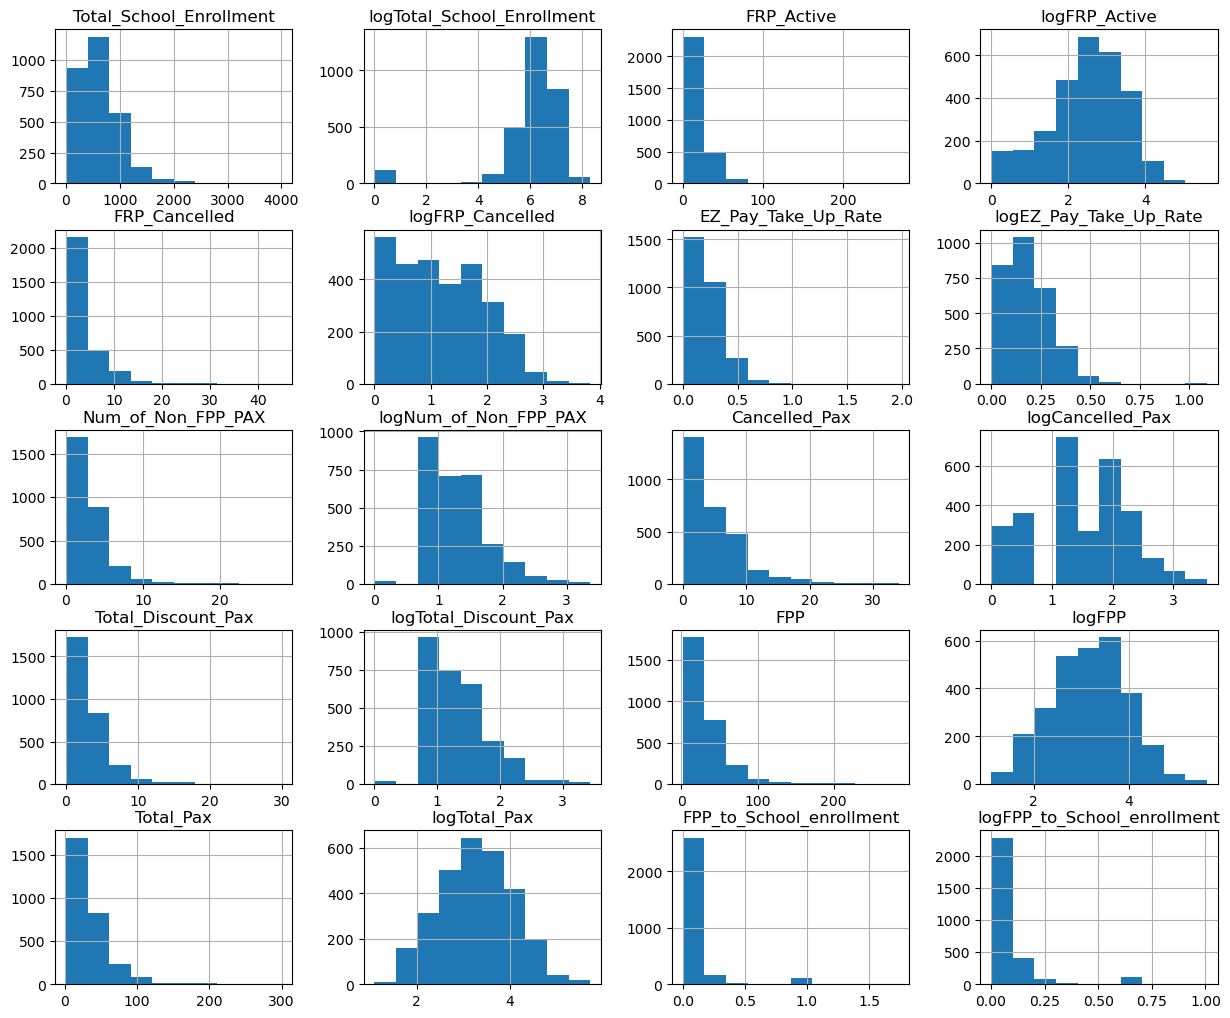

In [64]:
df_hist=X_train_num[['Total_School_Enrollment','logTotal_School_Enrollment','FRP_Active','logFRP_Active',
                     'FRP_Cancelled','logFRP_Cancelled','EZ_Pay_Take_Up_Rate','logEZ_Pay_Take_Up_Rate',
                     'Num_of_Non_FPP_PAX','logNum_of_Non_FPP_PAX','Cancelled_Pax','logCancelled_Pax',
                     'Total_Discount_Pax','logTotal_Discount_Pax','FPP','logFPP','Total_Pax','logTotal_Pax',
                     'FPP_to_School_enrollment','logFPP_to_School_enrollment']].hist(layout=(6,4), figsize=(15,15))

In [65]:
X_train_num

Total_School_Enrollment  NumberOfMeetingswithParents  \
2382                    255.0                          2.0   
1826                    227.0                          1.0   
4065                    443.0                          1.0   
2877                   1381.0                          2.0   
2241                    560.0                          1.0   
...                       ...                          ...   
2698                   1355.0                          1.0   
3430                    574.0                          2.0   
2015                    795.0                          0.0   
44                      824.0                          1.0   
2977                    576.0                          0.0   

      DifferenceTraveltoFirstMeeting  DifferenceTraveltoLastMeeting  Tuition  \
2382                           385.0                          239.0   1445.0   
1826                           262.0                          279.0   1661.0   
4065                           266.0                          267.0   1686.0   
2877                           314.0                          201.0   2589.0   
2241                           235.0                          219.0   1905.0   
...                              ...                            ...      ...   
2698                           157.0                          160.0    813.0   
3430                           272.0                          236.0   1879.0   
2015                             0.0                            0.0   1750.0   
44                             203.0                          187.0   1535.0   
2977                             0.0                            0.0   1457.0   

      FRP_Active  FRP_Cancelled  EZ_Pay_Take_Up_Rate  SPR_Group_Revenue  \
2382         9.0            0.0             0.477843             1365.0   
1826        25.0            3.0             0.296457             1535.0   
4065         6.0            4.0             0.331743             1868.0   
2877        14.0            7.0             0.236866             2505.0   
2241        23.0            3.0             0.203967             1970.0   
...          ...            ...                  ...                ...   
2698        14.0            4.0             0.290795              842.0   
3430        14.0            6.0             0.122232             2153.0   
2015         7.0            0.0             0.000000             1957.0   
44          42.0            5.0             0.205902             1293.0   
2977        19.0            0.0             0.275655             1725.0   

      Num_of_Non_FPP_PAX  ...  logTotal_School_Enrollment  logFRP_Active  \
2382                 1.0  ...                    5.545177       2.302585   
1826                 3.0  ...                    5.429346       3.258097   
4065                 1.0  ...                    6.095825       1.945910   
2877                 2.0  ...                    7.231287       2.708050   
2241                 4.0  ...                    6.329721       3.178054   
...                  ...  ...                         ...            ...   
2698                 2.0  ...                    7.212294       2.708050   
3430                 4.0  ...                    6.354370       2.708050   
2015                 1.0  ...                    6.679599       2.079442   
44                   6.0  ...                    6.715383       3.761200   
2977                 3.0  ...                    6.357842       2.995732   

      logFRP_Cancelled  logEZ_Pay_Take_Up_Rate  logNum_of_Non_FPP_PAX  \
2382          0.000000                0.390584               0.693147   
1826          1.386294                0.259635               1.386294   
4065          1.609438                0.286488               0.693147   
2877          2.079442                0.212581               1.098612   
2241          1.386294                0.185622               1.609438   
...                ...                     ...  

In [66]:
# Drop and use the log variables instead
X_train_num.drop(columns=['Total_School_Enrollment','FRP_Active','FRP_Cancelled','EZ_Pay_Take_Up_Rate',
                          'Num_of_Non_FPP_PAX','Cancelled_Pax','Total_Discount_Pax','FPP','Total_Pax',
                          'FPP_to_School_enrollment'],inplace=True)
X_train_num.columns

Index(['NumberOfMeetingswithParents', 'DifferenceTraveltoFirstMeeting',
       'DifferenceTraveltoLastMeeting', 'Tuition', 'SPR_Group_Revenue', 'Days',
       'FRP_Take_up_percent', 'FPP_to_PAX', 'logTotal_School_Enrollment',
       'logFRP_Active', 'logFRP_Cancelled', 'logEZ_Pay_Take_Up_Rate',
       'logNum_of_Non_FPP_PAX', 'logCancelled_Pax', 'logTotal_Discount_Pax',
       'logFPP', 'logTotal_Pax', 'logFPP_to_School_enrollment'],
      dtype='object')

In [67]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2899 entries, 2382 to 2977
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   NumberOfMeetingswithParents     2899 non-null   float64
 1   DifferenceTraveltoFirstMeeting  2899 non-null   float64
 2   DifferenceTraveltoLastMeeting   2899 non-null   float64
 3   Tuition                         2899 non-null   float64
 4   SPR_Group_Revenue               2899 non-null   float64
 5   Days                            2899 non-null   float64
 6   FRP_Take_up_percent             2899 non-null   float64
 7   FPP_to_PAX                      2899 non-null   float64
 8   logTotal_School_Enrollment      2899 non-null   float64
 9   logFRP_Active                   2899 non-null   float64
 10  logFRP_Cancelled                2899 non-null   float64
 11  logEZ_Pay_Take_Up_Rate          2899 non-null   float64
 12  logNum_of_Non_FPP_PAX          

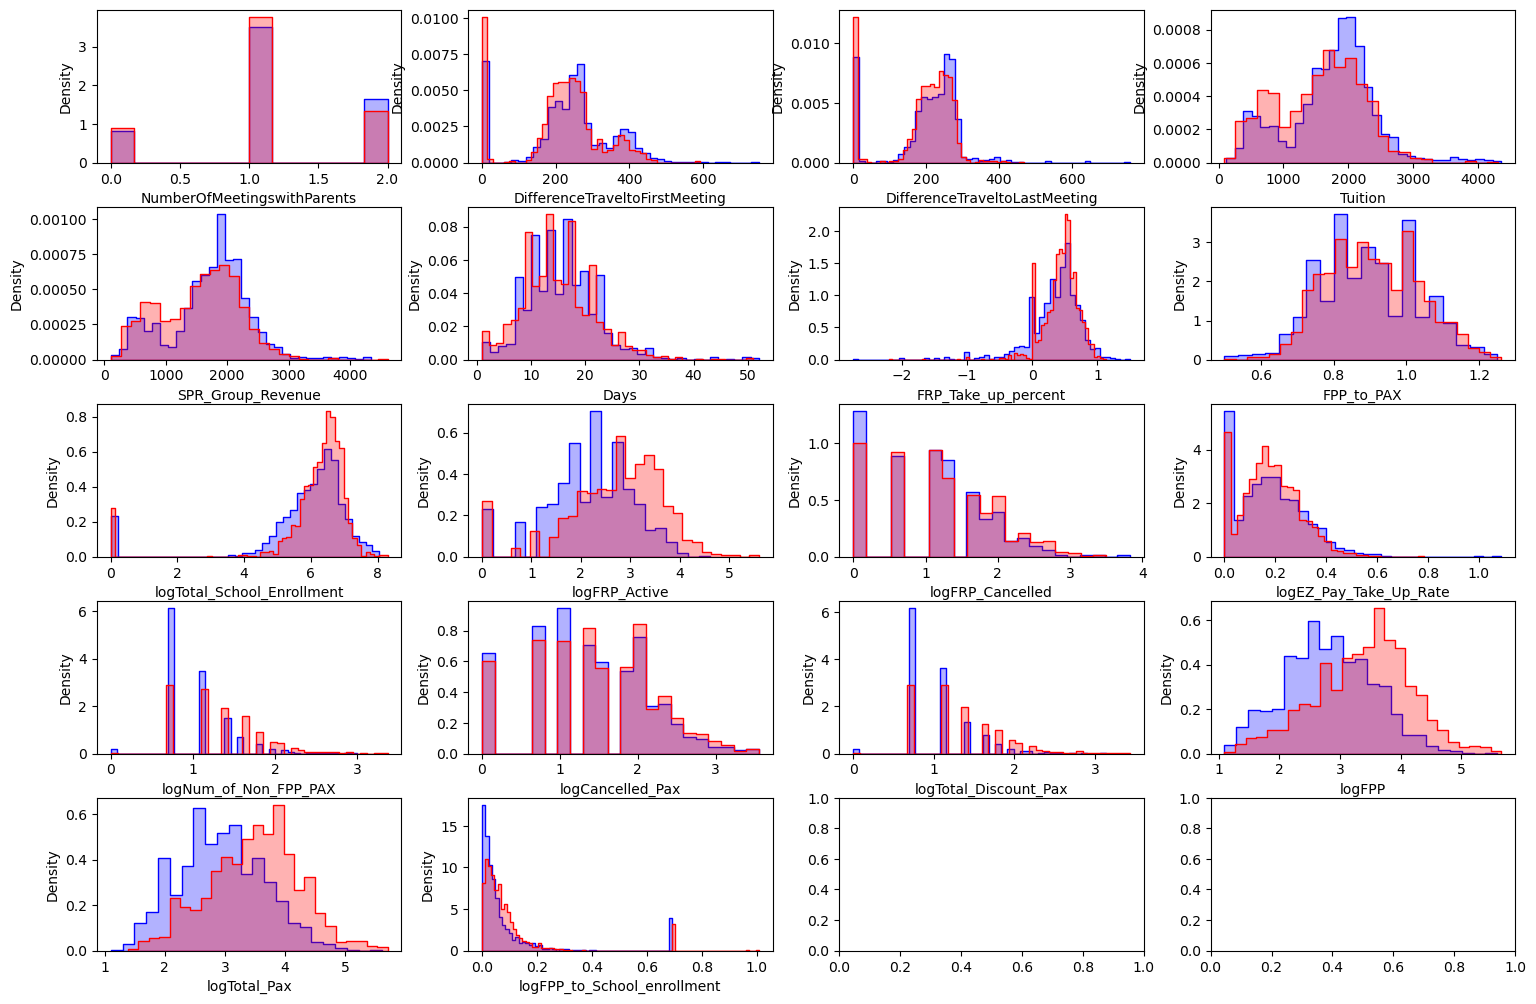

In [68]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


X0 = X_train_num[y_train==0] #not retained
X1 = X_train_num[y_train==1]

fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(15,10))
fig.tight_layout()

for i, ax in zip(range(X_train_num.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

#### Note
- logFPP -> customers that are retained have More full payment than customers that are not
- logTotal_Pax -> customers that are retained have More passengers in the trip than customers that are not
- logFRP_Active -> customers that are retained and made full payment bought More insurance than customers that are not

In [69]:
df_y_train=pd.DataFrame(y_train)
pd.concat([X_train_num,df_y_train],axis=1)

NumberOfMeetingswithParents  DifferenceTraveltoFirstMeeting  \
2382                          2.0                           385.0   
1826                          1.0                           262.0   
4065                          1.0                           266.0   
2877                          2.0                           314.0   
2241                          1.0                           235.0   
...                           ...                             ...   
2698                          1.0                           157.0   
3430                          2.0                           272.0   
2015                          0.0                             0.0   
44                            1.0                           203.0   
2977                          0.0                             0.0   

      DifferenceTraveltoLastMeeting  Tuition  SPR_Group_Revenue  Days  \
2382                          239.0   1445.0             1365.0  16.0   
1826                          279.0   1661.0             1535.0   9.0   
4065                          267.0   1686.0             1868.0  19.0   
2877                          201.0   2589.0             2505.0  18.0   
2241                          219.0   1905.0             1970.0   9.0   
...                             ...      ...                ...   ...   
2698                          160.0    813.0              842.0  10.0   
3430                          236.0   1879.0             2153.0  17.0   
2015                            0.0   1750.0             1957.0  14.0   
44                            187.0   1535.0             1293.0  21.0   
2977                            0.0   1457.0             1725.0  12.0   

      FRP_Take_up_percent  FPP_to_PAX  logTotal_School_Enrollment  \
2382             1.000000    0.818182                    5.545177   
1826             0.536585    0.820000                    5.429346   
4065             0.200000    0.909091                    6.095825   
2877             0.437500    0.800000                    7.231287   
2241             0.434783    0.901961                    6.329721   
...                   ...         ...                         ...   
2698             0.322581    1.107143                    7.212294   
3430             0.400000    0.769231                    6.354370   
2015             0.875000    0.800000                    6.679599   
44               0.480519    1.069444                    6.715383   
2977             0.593750    0.864865                    6.357842   

      logFRP_Active  logFRP_Cancelled  logEZ_Pay_Take_Up_Rate  \
2382       2.302585          0.000000                0.390584   
1826       3.258097          1.386294                0.259635   
4065       1.945910          1.609438                0.286488   
2877       2.708050          2.079442                0.212581   
2241       3.178054          1.386294                0.185622   
...             ...               ...                     ...   
2698       2.708050          1.609438                0.255259   
3430       2.708050          1.945910                0.115320   
2015       2.079442          0.000000                0.000000   
44         3.761200          1.791759                0.187228   
2977       2.995732          0.000000                0.243460   

      logNum_of_Non_FPP_PAX  logCancelled_Pax  logTotal_Discount_Pax  \
2382               0.693147          1.098612               0.693147   
1826               1.386294          1.791759               1.386294   
4065               0.693147          2.397895               0.693147   
2877               1.098612          2.197225               1.098612   
2241               1.609438          1.386294               1.609438   
...                     ...               ...                    ...   
2698               1.098612          1.609438               1.098612   
3430               1.609438          2.079442               1.791759   
2015               0.693147          0.000

In [70]:
# Create log variables on skewed features (Test)
X_test_num['logTotal_School_Enrollment']=X_test_num['Total_School_Enrollment'].apply(lambda x: math.log(x+1))
X_test_num['logFRP_Active']=X_test_num['FRP_Active'].apply(lambda x: math.log(x+1)) 
X_test_num['logFRP_Cancelled']=X_test_num['FRP_Cancelled'].apply(lambda x: math.log(x+1))
X_test_num['logEZ_Pay_Take_Up_Rate']=X_test_num['EZ_Pay_Take_Up_Rate'].apply(lambda x: math.log(x+1))
X_test_num['logNum_of_Non_FPP_PAX']=X_test_num['Num_of_Non_FPP_PAX'].apply(lambda x: math.log(x+1))
X_test_num['logCancelled_Pax']=X_test_num['Cancelled_Pax'].apply(lambda x: math.log(x+1))
X_test_num['logTotal_Discount_Pax']=X_test_num['Total_Discount_Pax'].apply(lambda x: math.log(x+1))
X_test_num['logFPP']=X_test_num['FPP'].apply(lambda x: math.log(x+1))
X_test_num['logTotal_Pax']=X_test_num['Total_Pax'].apply(lambda x: math.log(x+1))
X_test_num['logFPP_to_School_enrollment']=X_test_num['FPP_to_School_enrollment'].apply(lambda x: math.log(x+1))

In [71]:
X_test_num.drop(columns=['Total_School_Enrollment','FRP_Active','FRP_Cancelled','EZ_Pay_Take_Up_Rate',
                     'Num_of_Non_FPP_PAX','Cancelled_Pax','Total_Discount_Pax','FPP','Total_Pax','FPP_to_School_enrollment'],inplace=True) #use the log variables instead
X_test_num.columns

Index(['NumberOfMeetingswithParents', 'DifferenceTraveltoFirstMeeting',
       'DifferenceTraveltoLastMeeting', 'Tuition', 'SPR_Group_Revenue', 'Days',
       'FRP_Take_up_percent', 'FPP_to_PAX', 'logTotal_School_Enrollment',
       'logFRP_Active', 'logFRP_Cancelled', 'logEZ_Pay_Take_Up_Rate',
       'logNum_of_Non_FPP_PAX', 'logCancelled_Pax', 'logTotal_Discount_Pax',
       'logFPP', 'logTotal_Pax', 'logFPP_to_School_enrollment'],
      dtype='object')

### Scaling

In [72]:
from sklearn.preprocessing import StandardScaler

#  Create scaler
scaler = StandardScaler().fit(X_train_num) # No target

# Transform both
X_train_num_scaled=pd.DataFrame(scaler.transform(X_train_num))
X_test_num_scaled=pd.DataFrame(scaler.transform(X_test_num))

X_train_num_scaled.columns = X_train_num.columns
X_test_num_scaled.columns = X_test_num.columns

In [73]:
X_test_num_scaled

NumberOfMeetingswithParents  DifferenceTraveltoFirstMeeting  \
0                       -0.162471                        0.286943   
1                       -0.162471                       -0.231210   
2                       -0.162471                        0.303931   
3                       -0.162471                       -0.197233   
4                       -0.162471                       -0.460556   
...                           ...                             ...   
1238                     1.461683                       -0.341636   
1239                     1.461683                        1.637537   
1240                    -0.162471                        0.295437   
1241                    -1.786626                       -1.904588   
1242                    -1.786626                       -1.904588   

      DifferenceTraveltoLastMeeting   Tuition  SPR_Group_Revenue      Days  \
0                          0.515276  0.330507          -0.022049 -0.194383   
1                         -0.154745  0.928493           0.859727  1.901029   
2                          0.706710  0.520776           0.617163  0.853323   
3                          0.143042  1.102151           1.207556  1.901029   
4                         -0.080298 -0.770330          -0.836701 -0.493727   
...                             ...       ...                ...       ...   
1238                      -0.261097  0.763896           0.780398  0.553978   
1239                       1.844681 -0.188955          -0.025101  0.553978   
1240                       0.685439 -0.596673          -0.546844 -0.643400   
1241                      -2.079724 -1.822846          -1.810012 -1.990450   
1242                      -2.079724 -0.483418          -0.739065 -0.493727   

      FRP_Take_up_percent  FPP_to_PAX  logTotal_School_Enrollment  \
0                0.725991    1.372850                    0.657333   
1               -0.455042   -0.351017                    0.172649   
2                0.674844   -0.467337                   -0.487750   
3                0.503649   -0.793034                    0.594958   
4                0.875712    0.050817                    0.307786   
...                   ...         ...                         ...   
1238             0.599518    0.270570                    0.121231   
1239             0.564070    1.785400                    0.163202   
1240             0.659778    0.993262                    0.378455   
1241            -0.173976    0.640272                    0.224352   
1242             0.465606    0.477766                   -0.151038   

      logFRP_Active  logFRP_Cancelled  logEZ_Pay_Take_Up_Rate  \
0          1.581571          0.553056                0.264308   
1         -0.541352          0.266789               -0.783450   
2          0.004271         -0.622438               -1.052111   
3          0.965019          0.786953                0.817258   
4          2.009626          0.266789                0.293052   
...             ...               ...                     ...   
1238       0.004271         -0.102274                0.754390   
1239       0.085297         -0.102274               -0.543863   
1240       1.774975          0.984710                0.137244   
1241       0.705939         -1.511664                0.421397   
1242       0.469452          0.266789               -0.372149   

      logNum_of_Non_FPP_PAX  logCancelled_Pax  logTotal_Discount_Pax  \
0                  1.392189          0.584803               1.393520   
1                 -1.006090         -0.134196              -0.999320   
2                 -1.006090         -1.024758              -0.999320   
3                  1.647820         -0.134196               1.648572   
4                  2.424039          0.152501               2.074787   
...                     ...               ...                    ...   
1238              -0.229871         -0.503813              -0.224861   
1239              -1.006090         -1.024758         

In [74]:
# Save the scaler
import pickle
pickle.dump(scaler, open('scaler.pkl', 'wb'))


<AxesSubplot:>

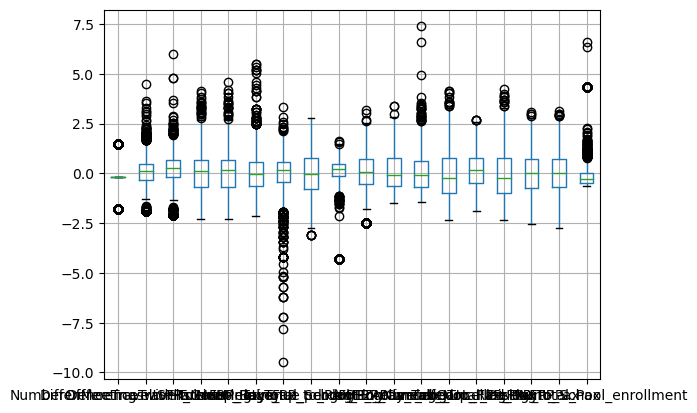

In [75]:
X_train_num_scaled.boxplot()

## Final Dataset

In [76]:
# Put together
X_train=pd.concat([dummies_train,X_train_num_scaled], axis=1)
X_test=pd.concat([dummies_test,X_test_num_scaled], axis=1)

In [77]:
X_train

Poverty_Code_0  Poverty_Code_A  Poverty_Code_B  Poverty_Code_C  \
0                0.0             0.0             1.0             0.0   
1                0.0             0.0             1.0             0.0   
2                0.0             0.0             0.0             0.0   
3                0.0             0.0             1.0             0.0   
4                0.0             0.0             1.0             0.0   
...              ...             ...             ...             ...   
2894             0.0             0.0             1.0             0.0   
2895             0.0             0.0             0.0             1.0   
2896             0.0             0.0             1.0             0.0   
2897             1.0             0.0             0.0             0.0   
2898             0.0             0.0             1.0             0.0   

      Poverty_Code_D  Poverty_Code_E  Region_Dallas  Region_Houston  \
0                0.0             0.0            0.0             0.0   
1                0.0             0.0            0.0             0.0   
2                1.0             0.0            0.0             1.0   
3                0.0             0.0            0.0             0.0   
4                0.0             0.0            0.0             0.0   
...              ...             ...            ...             ...   
2894             0.0             0.0            0.0             0.0   
2895             0.0             0.0            0.0             1.0   
2896             0.0             0.0            0.0             1.0   
2897             0.0             0.0            0.0             0.0   
2898             0.0             0.0            0.0             0.0   

      Region_Northern California  Region_Other  ...  \
0                            0.0           1.0  ...   
1                            0.0           1.0  ...   
2                            0.0           0.0  ...   
3                            0.0           1.0  ...   
4                            0.0           1.0  ...   
...                          ...           ...  ...   
2894                         0.0           1.0  ...   
2895                         0.0           0.0  ...   
2896                         0.0           0.0  ...   
2897                         0.0           1.0  ...   
2898                         0.0           1.0  ...   

      logTotal_School_Enrollment  logFRP_Active  logFRP_Cancelled  \
0                      -0.346744      -0.180292         -1.511664   
1                      -0.429204       0.786966          0.266789   
2                       0.045263      -0.541352          0.553056   
3                       0.853600       0.230158          1.156015   
4                       0.211774       0.705939          0.266789   
...                          ...            ...               ...   
2894                    0.840080       0.230158          0.553056   
2895                    0.229322       0.230158          0.984710   
2896                    0.460853      -0.406179         -1.511664   
2897                    0.486328       1.296255          0.786953   
2898                    0.231794       0.521376         -1.511664   

      logEZ_Pay_Take_Up_Rate  logNum_of_Non_FPP_PAX  logCancelled_Pax  \
0                   1.713968              -1.006090         -0.503813   
1                   0.650925               0.320865          0.386749   
2                   0.868918              -1.006090          1.165518   
3                   0.268933              -0.229871          0.907694   
4                   0.050079               0.748049         -0.134196   
...                      ...                    ...               ...   
2894                0.615394              -0.229871          0.152501   
2895               -0.520633               0.748049          0.756366   
2896               -1.456804              -1.006090         -1.915320   
2897                0.063116               1.392189          0.38674

## Models

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import time
from scipy import stats

### KNN

In [79]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(10,500,20)} 

def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=1, n_jobs=-1)
    
    tic = time.perf_counter()
    gs = gs.fit(X_train, y_train)
    toc = time.perf_counter()

    print("f1_train: %f using %s in %.3f seconds" % (gs.best_score_, gs.best_params_,toc - tic))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    print("           train    test ") # to understand the model
    print("f1         %.3f    %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred) )) 
    print("precision  %.3f    %.3f" % (precision_score(y_train, y_pred_train), precision_score(y_test, y_pred) )) 
    print("")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [80]:
hyperp_search(classifier,parameters)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
f1_train: 0.774053 using {'n_neighbors': 50} in 12.397 seconds
           train    test 
f1         0.789    0.769
precision  0.707    0.684

[[181 307]
 [ 92 663]]
              precision    recall  f1-score   support

       False       0.66      0.37      0.48       488
        True       0.68      0.88      0.77       755

    accuracy                           0.68      1243
   macro avg       0.67      0.62      0.62      1243
weighted avg       0.68      0.68      0.65      1243



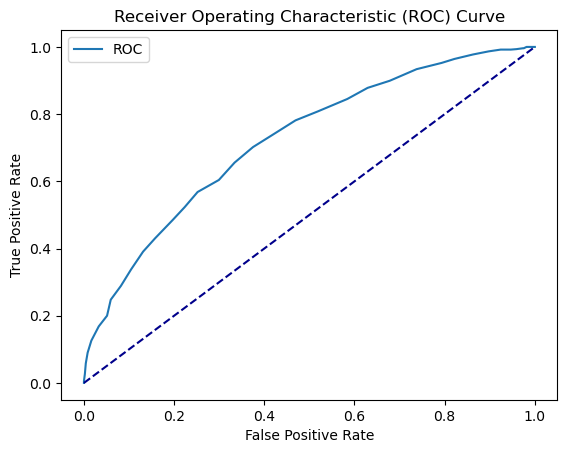

AUC: 0.72


In [81]:
model_knn = KNeighborsClassifier(n_neighbors=50)

def roc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

    fpr, tpr, thresholds1=metrics.roc_curve(y_test,  y_probs[:,1])

    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    auc = metrics.roc_auc_score(y_test, y_probs[:,1])
    print('AUC: %.2f' % auc)
    return (fpr, tpr)

fpr1,tpr1=roc(model_knn,X_train,y_train,X_test,y_test)

### Decision tree

In [82]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [3,5,6,8,10,15],
              'min_samples_split': [5,10,20],
              'min_samples_leaf': [5,10,20]}

hyperp_search(classifier,parameters)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
f1_train: 0.755030 using {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 20} in 4.240 seconds
           train    test 
f1         0.801    0.720
precision  0.801    0.718

[[274 214]
 [210 545]]
              precision    recall  f1-score   support

       False       0.57      0.56      0.56       488
        True       0.72      0.72      0.72       755

    accuracy                           0.66      1243
   macro avg       0.64      0.64      0.64      1243
weighted avg       0.66      0.66      0.66      1243



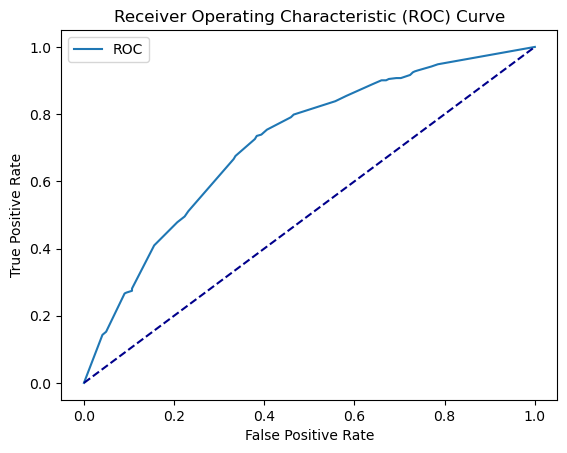

AUC: 0.72


In [83]:
model_tree = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=5, min_samples_split=5)

fpr2,tpr2=roc(model_tree,X_train,y_train,X_test,y_test)

### Plotting the tree

In [84]:
from sklearn import tree
r = tree.export_text(model_tree,feature_names=X_test.columns.tolist(),max_depth=3)
print(r)

|--- logTotal_Pax <= -0.03
|   |--- SchoolGradeType_High->High <= 0.50
|   |   |--- logTotal_Pax <= -0.75
|   |   |   |--- Income_Level_M <= 0.50
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- Income_Level_M >  0.50
|   |   |   |   |--- truncated branch of depth 5
|   |   |--- logTotal_Pax >  -0.75
|   |   |   |--- Group_State_WA <= 0.50
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- Group_State_WA >  0.50
|   |   |   |   |--- truncated branch of depth 4
|   |--- SchoolGradeType_High->High >  0.50
|   |   |--- Program_Code_SG <= 0.50
|   |   |   |--- Tuition <= -0.34
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- Tuition >  -0.34
|   |   |   |   |--- truncated branch of depth 6
|   |   |--- Program_Code_SG >  0.50
|   |   |   |--- class: True
|--- logTotal_Pax >  -0.03
|   |--- logFRP_Active <= 0.81
|   |   |--- SchoolGradeType_Middle->High <= 0.50
|   |   |   |--- SchoolGradeType_High->High <= 0.50
|   |   |   |   |--- truncated

Important variables
1. logTotal_Pax (total passengers)
the higher the logTotal_Pax -> the more likely the customers will not retained??
2. SchoolGradeType_High->High
3. logTotal_Pax
4. Income_Level_M

### Naive Bayes

In [85]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

model.fit(X_train, y_train)
y_pred=model.predict(X_test)

from sklearn.metrics import f1_score
print("f1_score: ", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1_score:  0.7655786350148368
[[203 285]
 [110 645]]
              precision    recall  f1-score   support

       False       0.65      0.42      0.51       488
        True       0.69      0.85      0.77       755

    accuracy                           0.68      1243
   macro avg       0.67      0.64      0.64      1243
weighted avg       0.68      0.68      0.66      1243



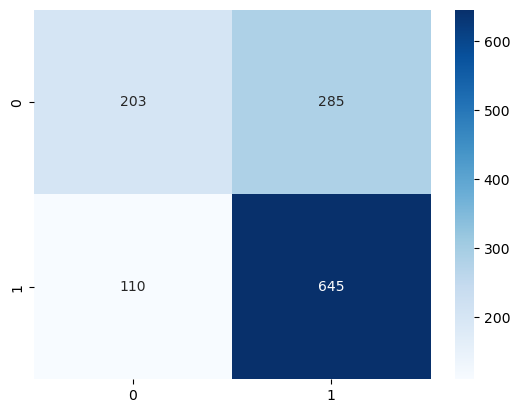

In [86]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); 

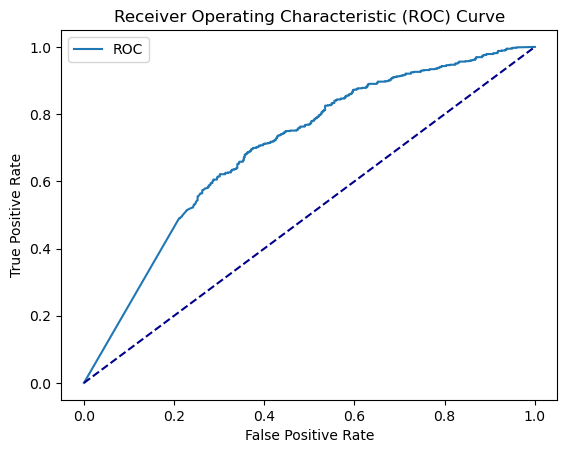

AUC: 0.70


In [87]:
y_probs = model.predict_proba(X_test)

fpr3,tpr3=roc(model,X_train,y_train,X_test,y_test)

### Logistic regression

In [88]:
# DEFINE CLASSIFIER and THE PARAMETERS GRID
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10],"penalty":['l2'] , "max_iter":[1000,5000]}

# Define Gridsearch
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'recall', verbose=50, n_jobs=-1, refit=True)

hyperp_search(classifier,parameters)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
f1_train: 0.787696 using {'C': 1, 'max_iter': 1000, 'penalty': 'l2'} in 2.084 seconds
           train    test 
f1         0.824    0.800
precision  0.785    0.755

[[280 208]
 [113 642]]
              precision    recall  f1-score   support

       False       0.71      0.57      0.64       488
        True       0.76      0.85      0.80       755

    accuracy                           0.74      1243
   macro avg       0.73      0.71      0.72      1243
weighted avg       0.74      0.74      0.74      1243



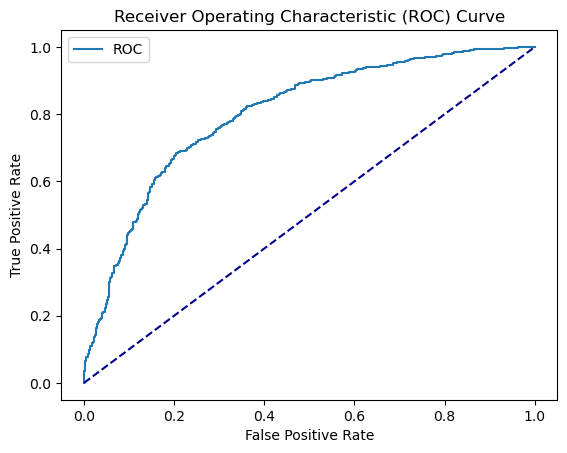

AUC: 0.80


In [89]:
model = LogisticRegression(C=1,penalty='l2', max_iter=1000)
fpr4,tpr4=roc(model,X_train,y_train,X_test,y_test)

In [90]:
model.fit(X_train,y_train)

coeff=pd.DataFrame()
coeff["feature"]=X_train.columns
coeff["w"]=model.coef_[0]

coeff.sort_values(by=['w'], inplace=True)

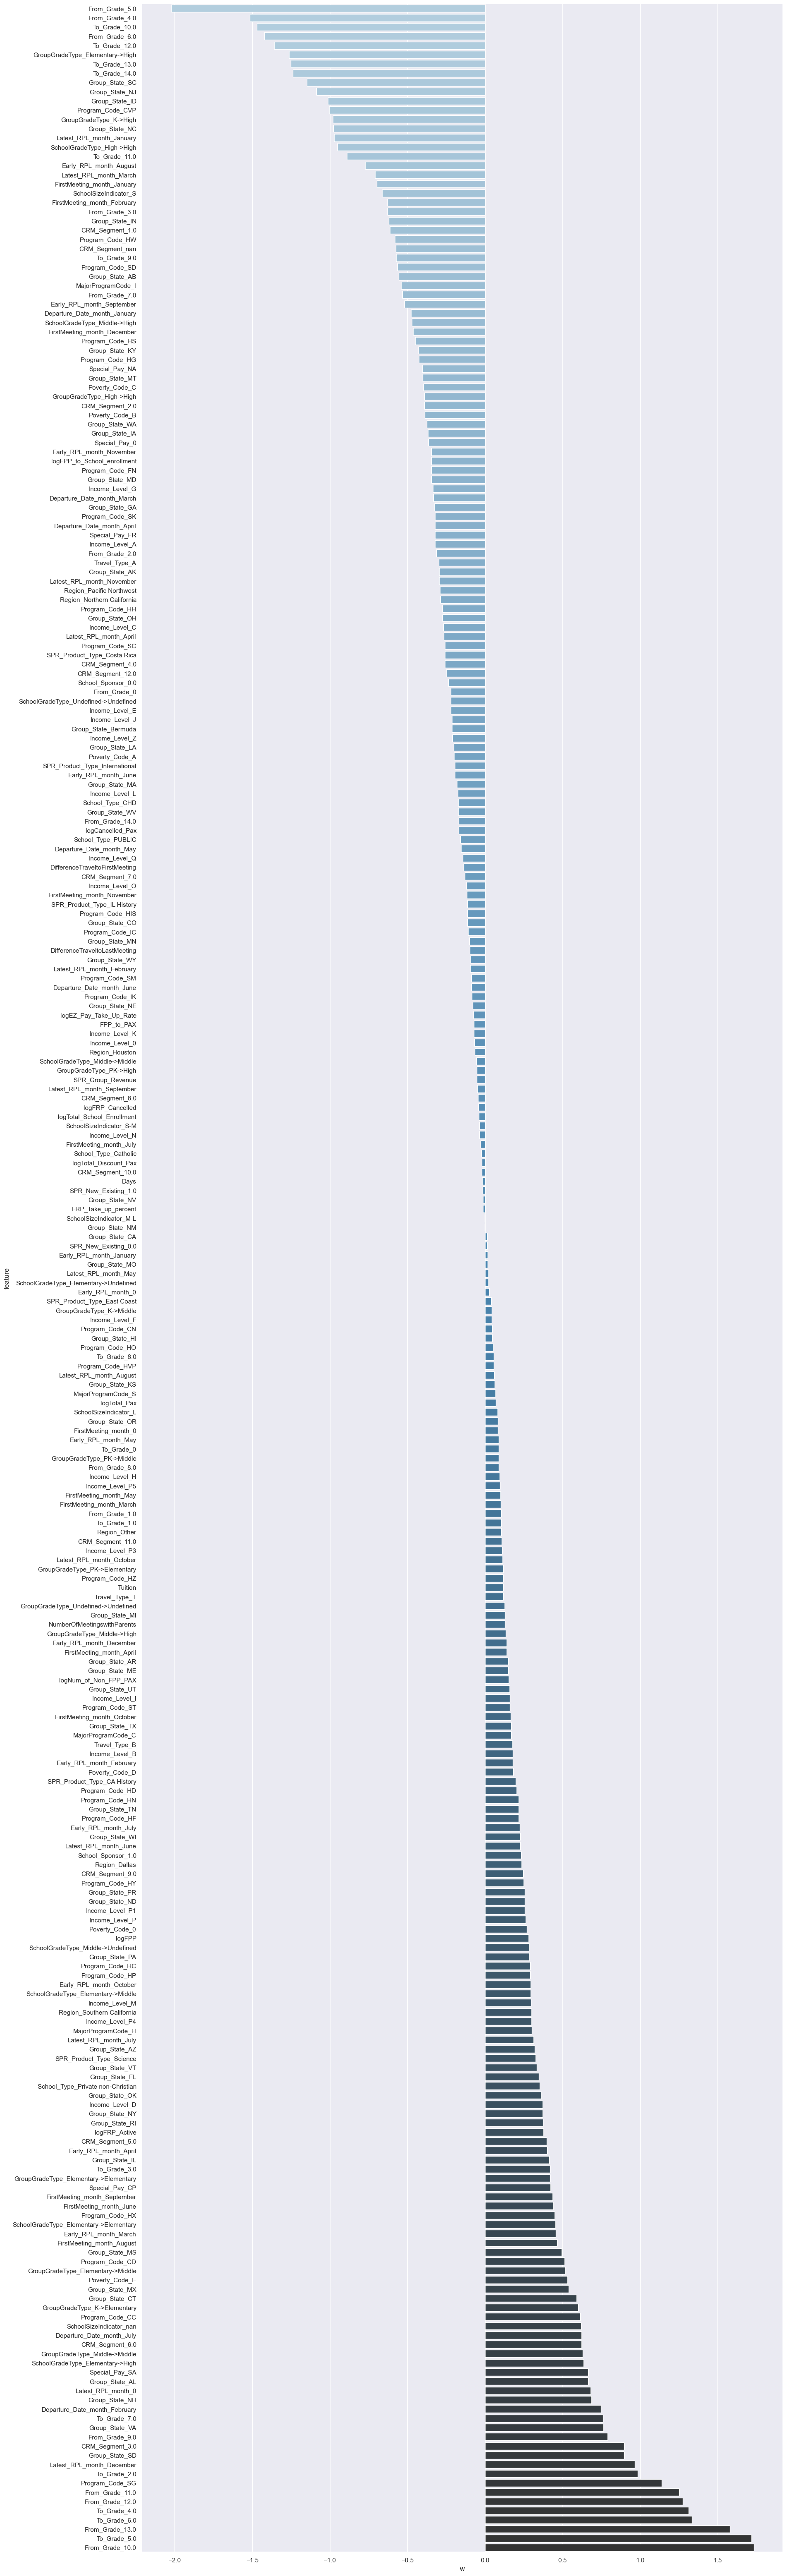

In [91]:
sns.set(rc={'figure.figsize':(20,80)})
sns.barplot(data=coeff, y="feature", x="w", palette="Blues_d", orient="h")
sns.set(rc={'figure.figsize':(30,20)})

Important features
- From_Grade_10(+)
- To_Grade_5(+)
- From_Grade_13(+)
- From_Grade_5(-)
- From_Grade_4(-)
- To_Grade_10(-)

### SVM

In [92]:
from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear','rbf'], "C":[0.1,1,200]}

hyperp_search(classifier,parameters)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
f1_train: 0.822077 using {'C': 200, 'kernel': 'rbf'} in 146.119 seconds
           train    test 
f1         1.000    0.865
precision  1.000    0.839

[[358 130]
 [ 80 675]]
              precision    recall  f1-score   support

       False       0.82      0.73      0.77       488
        True       0.84      0.89      0.87       755

    accuracy                           0.83      1243
   macro avg       0.83      0.81      0.82      1243
weighted avg       0.83      0.83      0.83      1243



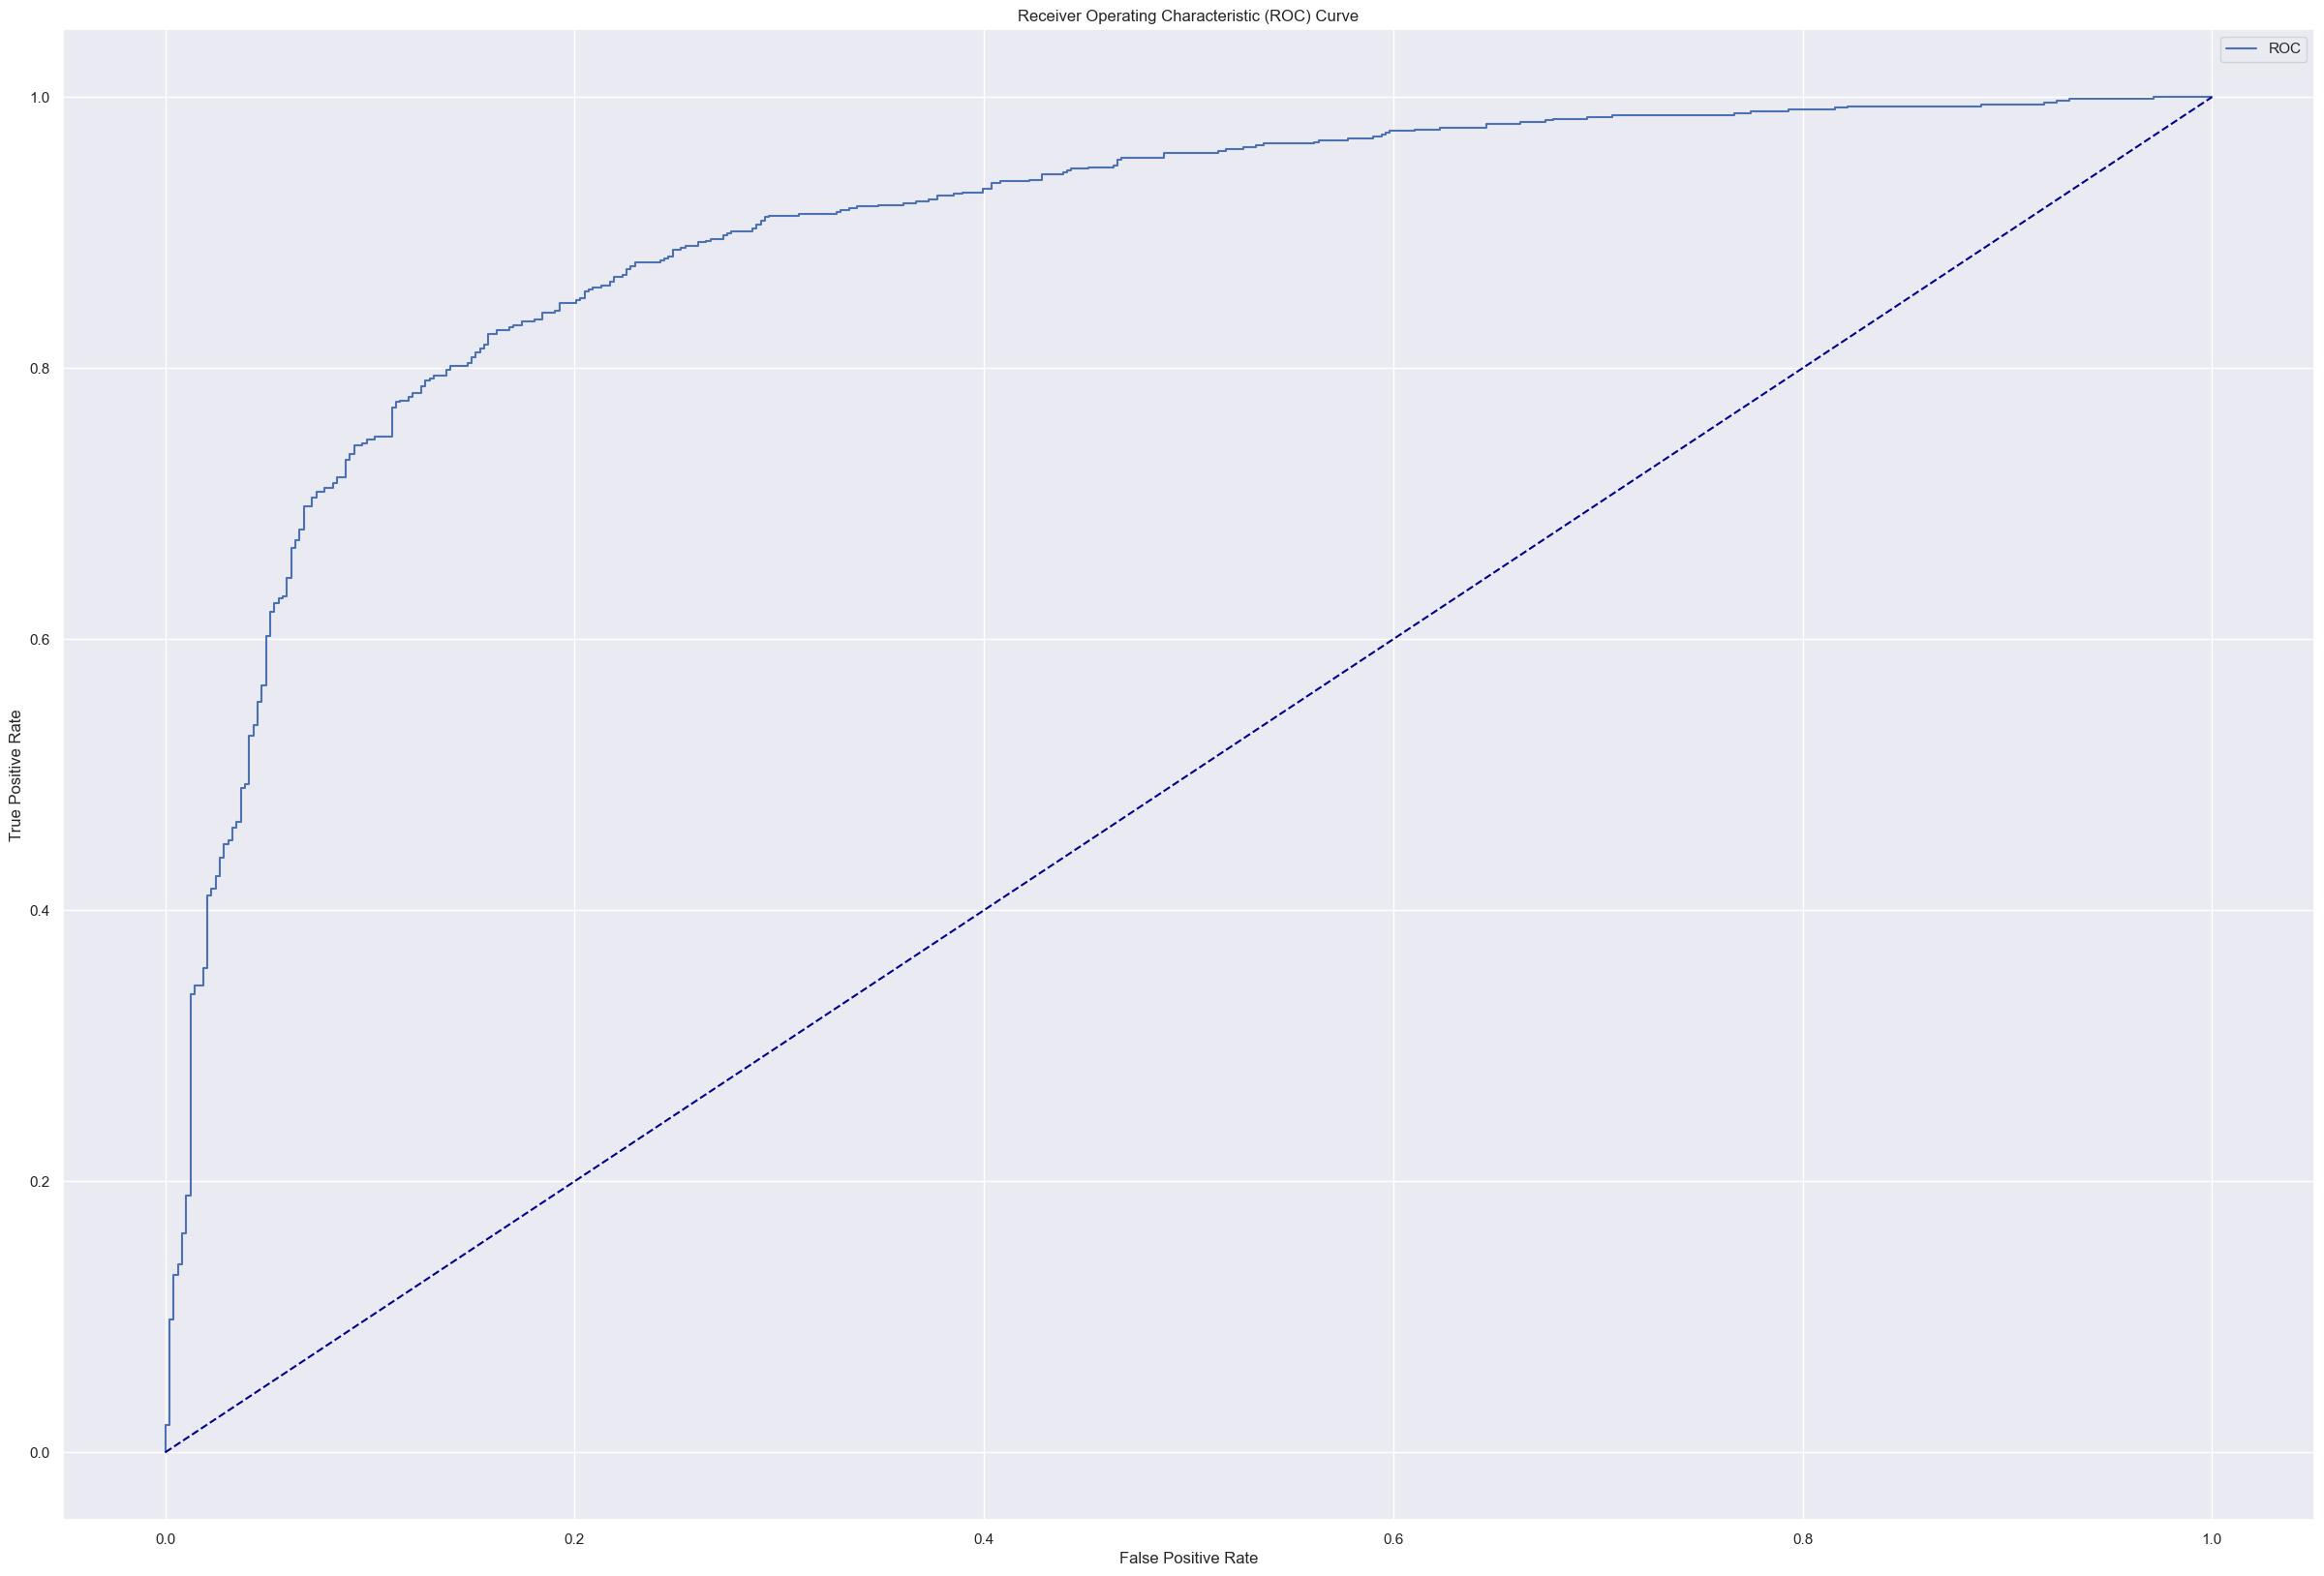

AUC: 0.90


In [93]:
model = SVC(C=200, kernel='rbf',probability=True)

fpr5,tpr5=roc(model,X_train,y_train,X_test,y_test)

### Multi-layer Perceptron classifier

In [94]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(10, 5),(100,20,5)],  "max_iter": [1000,5000], "alpha": [0.001,0.1,10]}

hyperp_search(classifier,parameters)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
f1_train: 0.812613 using {'alpha': 0.001, 'hidden_layer_sizes': (100, 20, 5), 'max_iter': 5000} in 58.246 seconds
           train    test 
f1         1.000    0.838
precision  1.000    0.815

[[340 148]
 [104 651]]
              precision    recall  f1-score   support

       False       0.77      0.70      0.73       488
        True       0.81      0.86      0.84       755

    accuracy                           0.80      1243
   macro avg       0.79      0.78      0.78      1243
weighted avg       0.80      0.80      0.80      1243



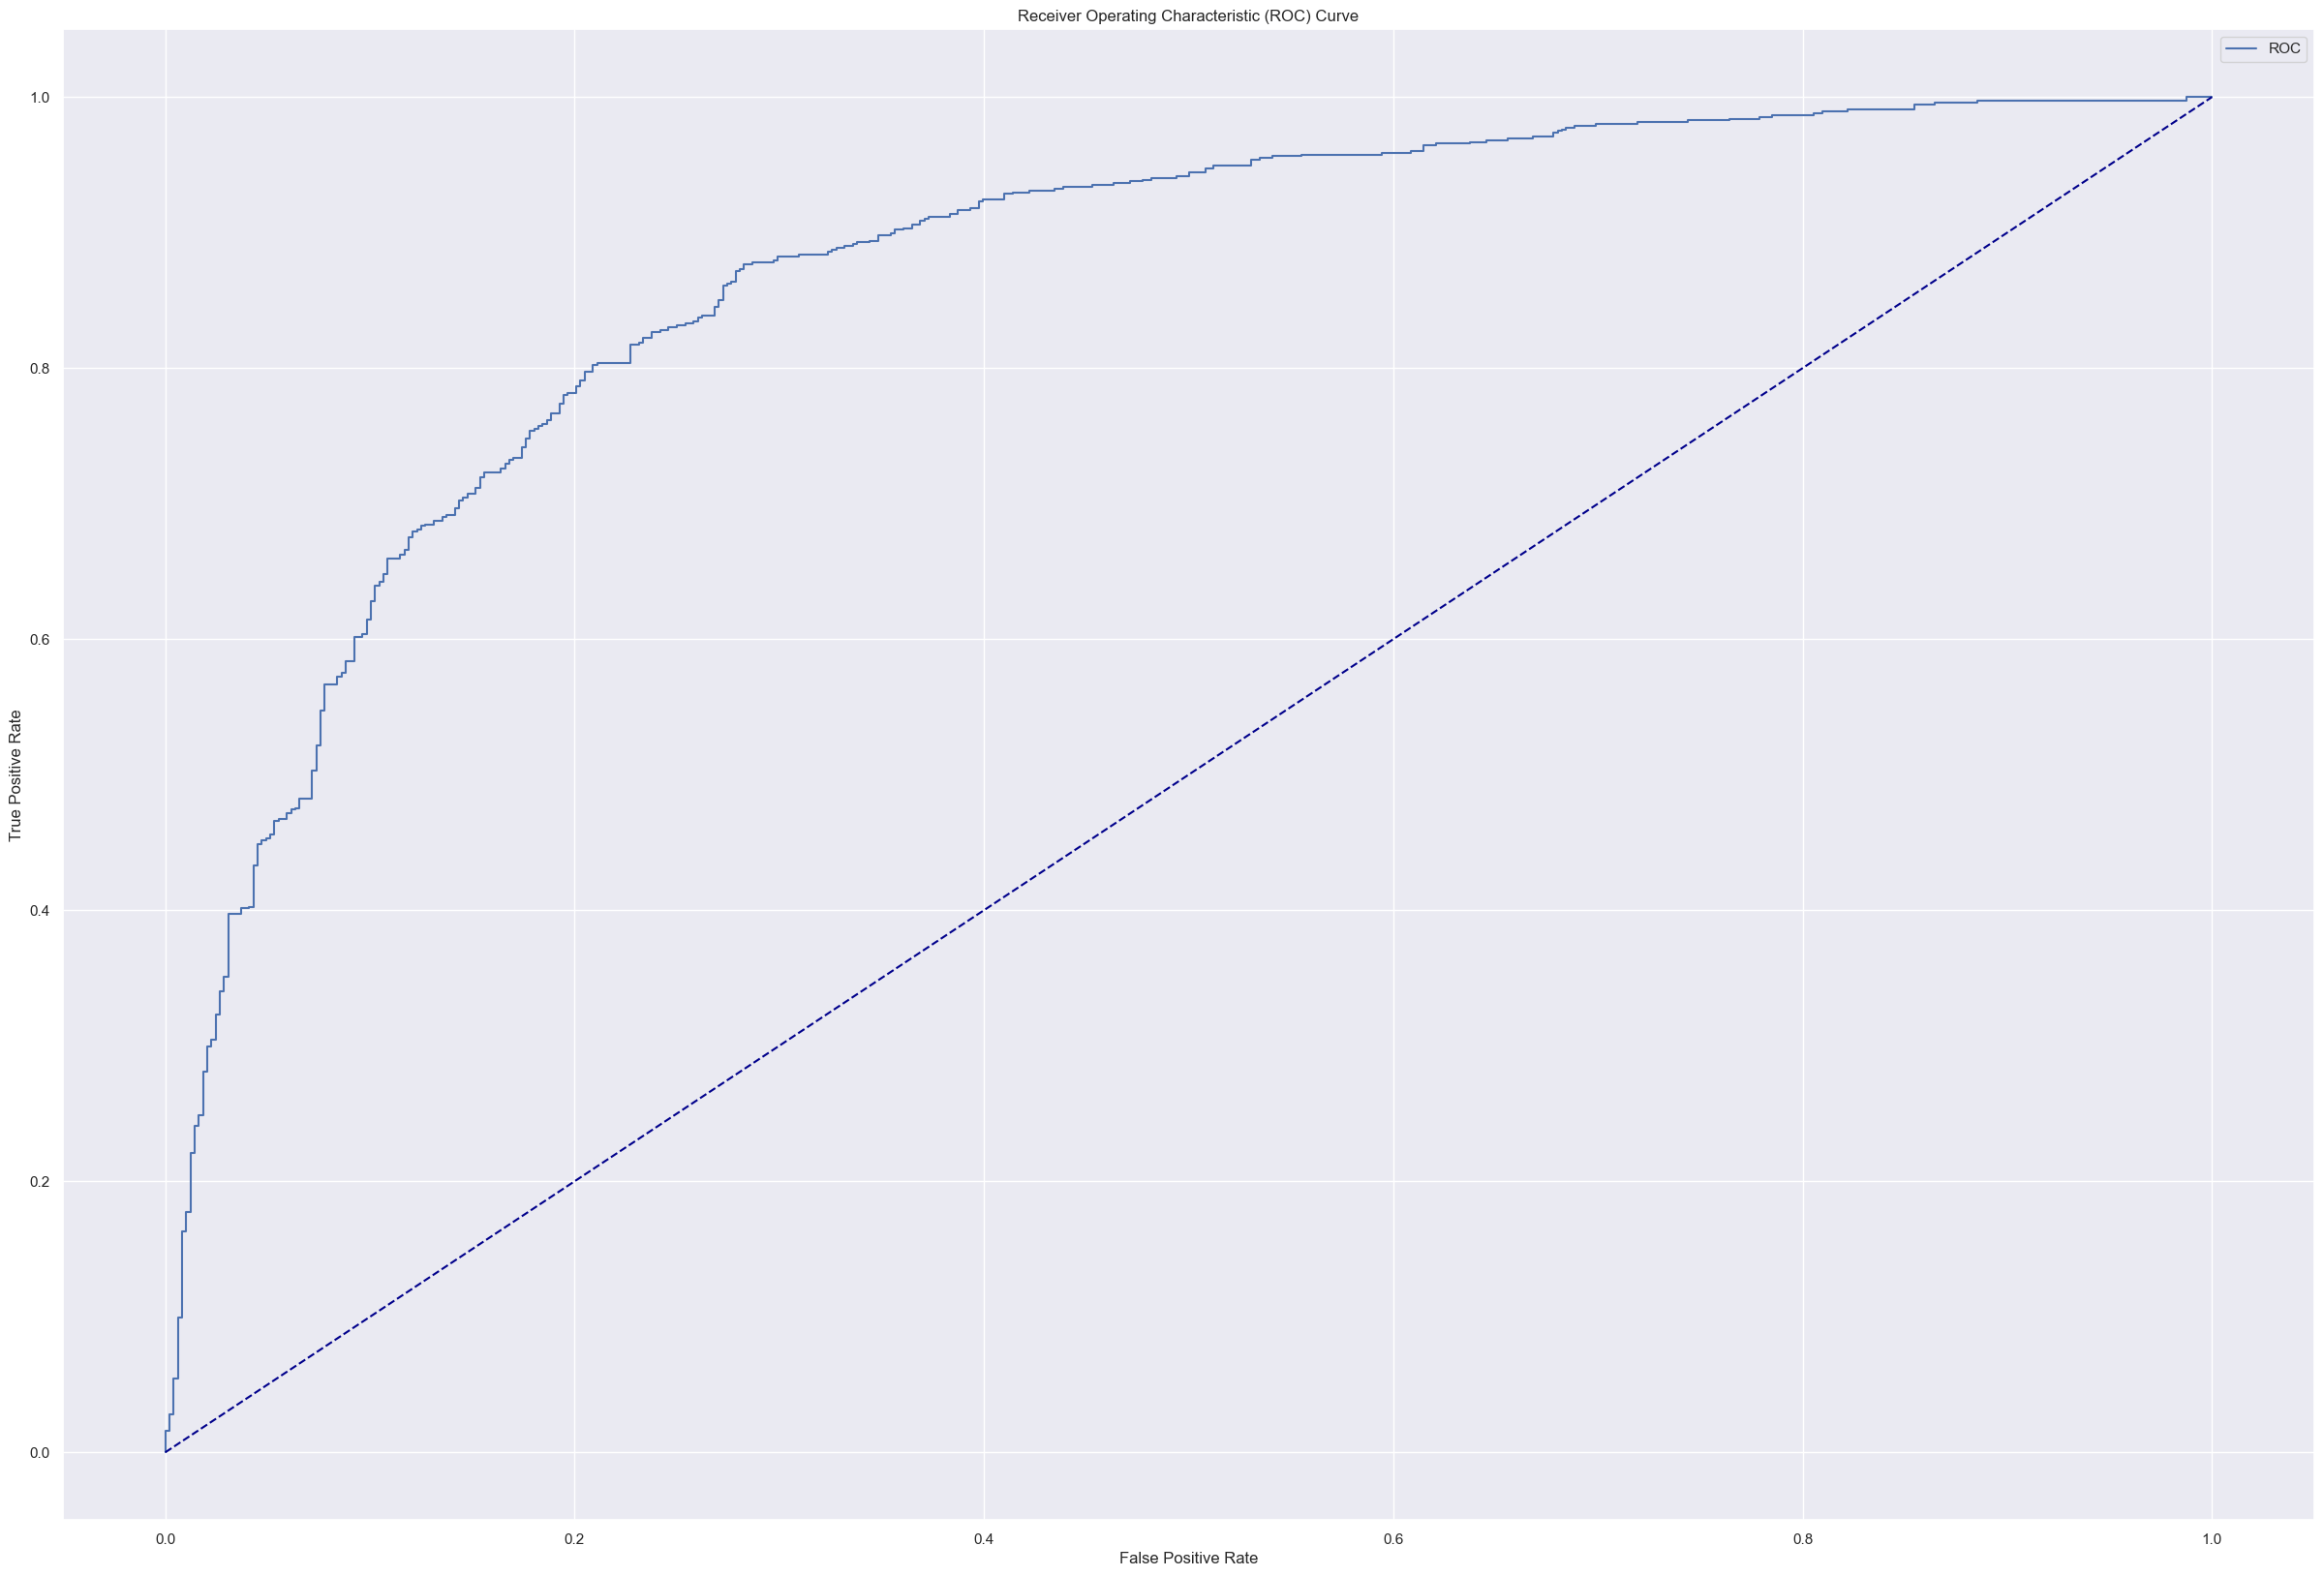

AUC: 0.87


In [95]:
model_MLP=MLPClassifier(hidden_layer_sizes=(100, 20, 5), alpha=0.01, max_iter=1000)

fpr6,tpr6=roc(model_MLP,X_train,y_train,X_test,y_test)

### Adaboost

In [96]:
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier()
parameters = {"n_estimators":[10,30,100],
            "learning_rate":[0.01,0.5,1.0]}

hyperp_search(classifier,parameters)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
f1_train: 0.772171 using {'learning_rate': 0.5, 'n_estimators': 100} in 7.269 seconds
           train    test 
f1         0.815    0.775
precision  0.769    0.732

[[261 227]
 [134 621]]
              precision    recall  f1-score   support

       False       0.66      0.53      0.59       488
        True       0.73      0.82      0.77       755

    accuracy                           0.71      1243
   macro avg       0.70      0.68      0.68      1243
weighted avg       0.70      0.71      0.70      1243



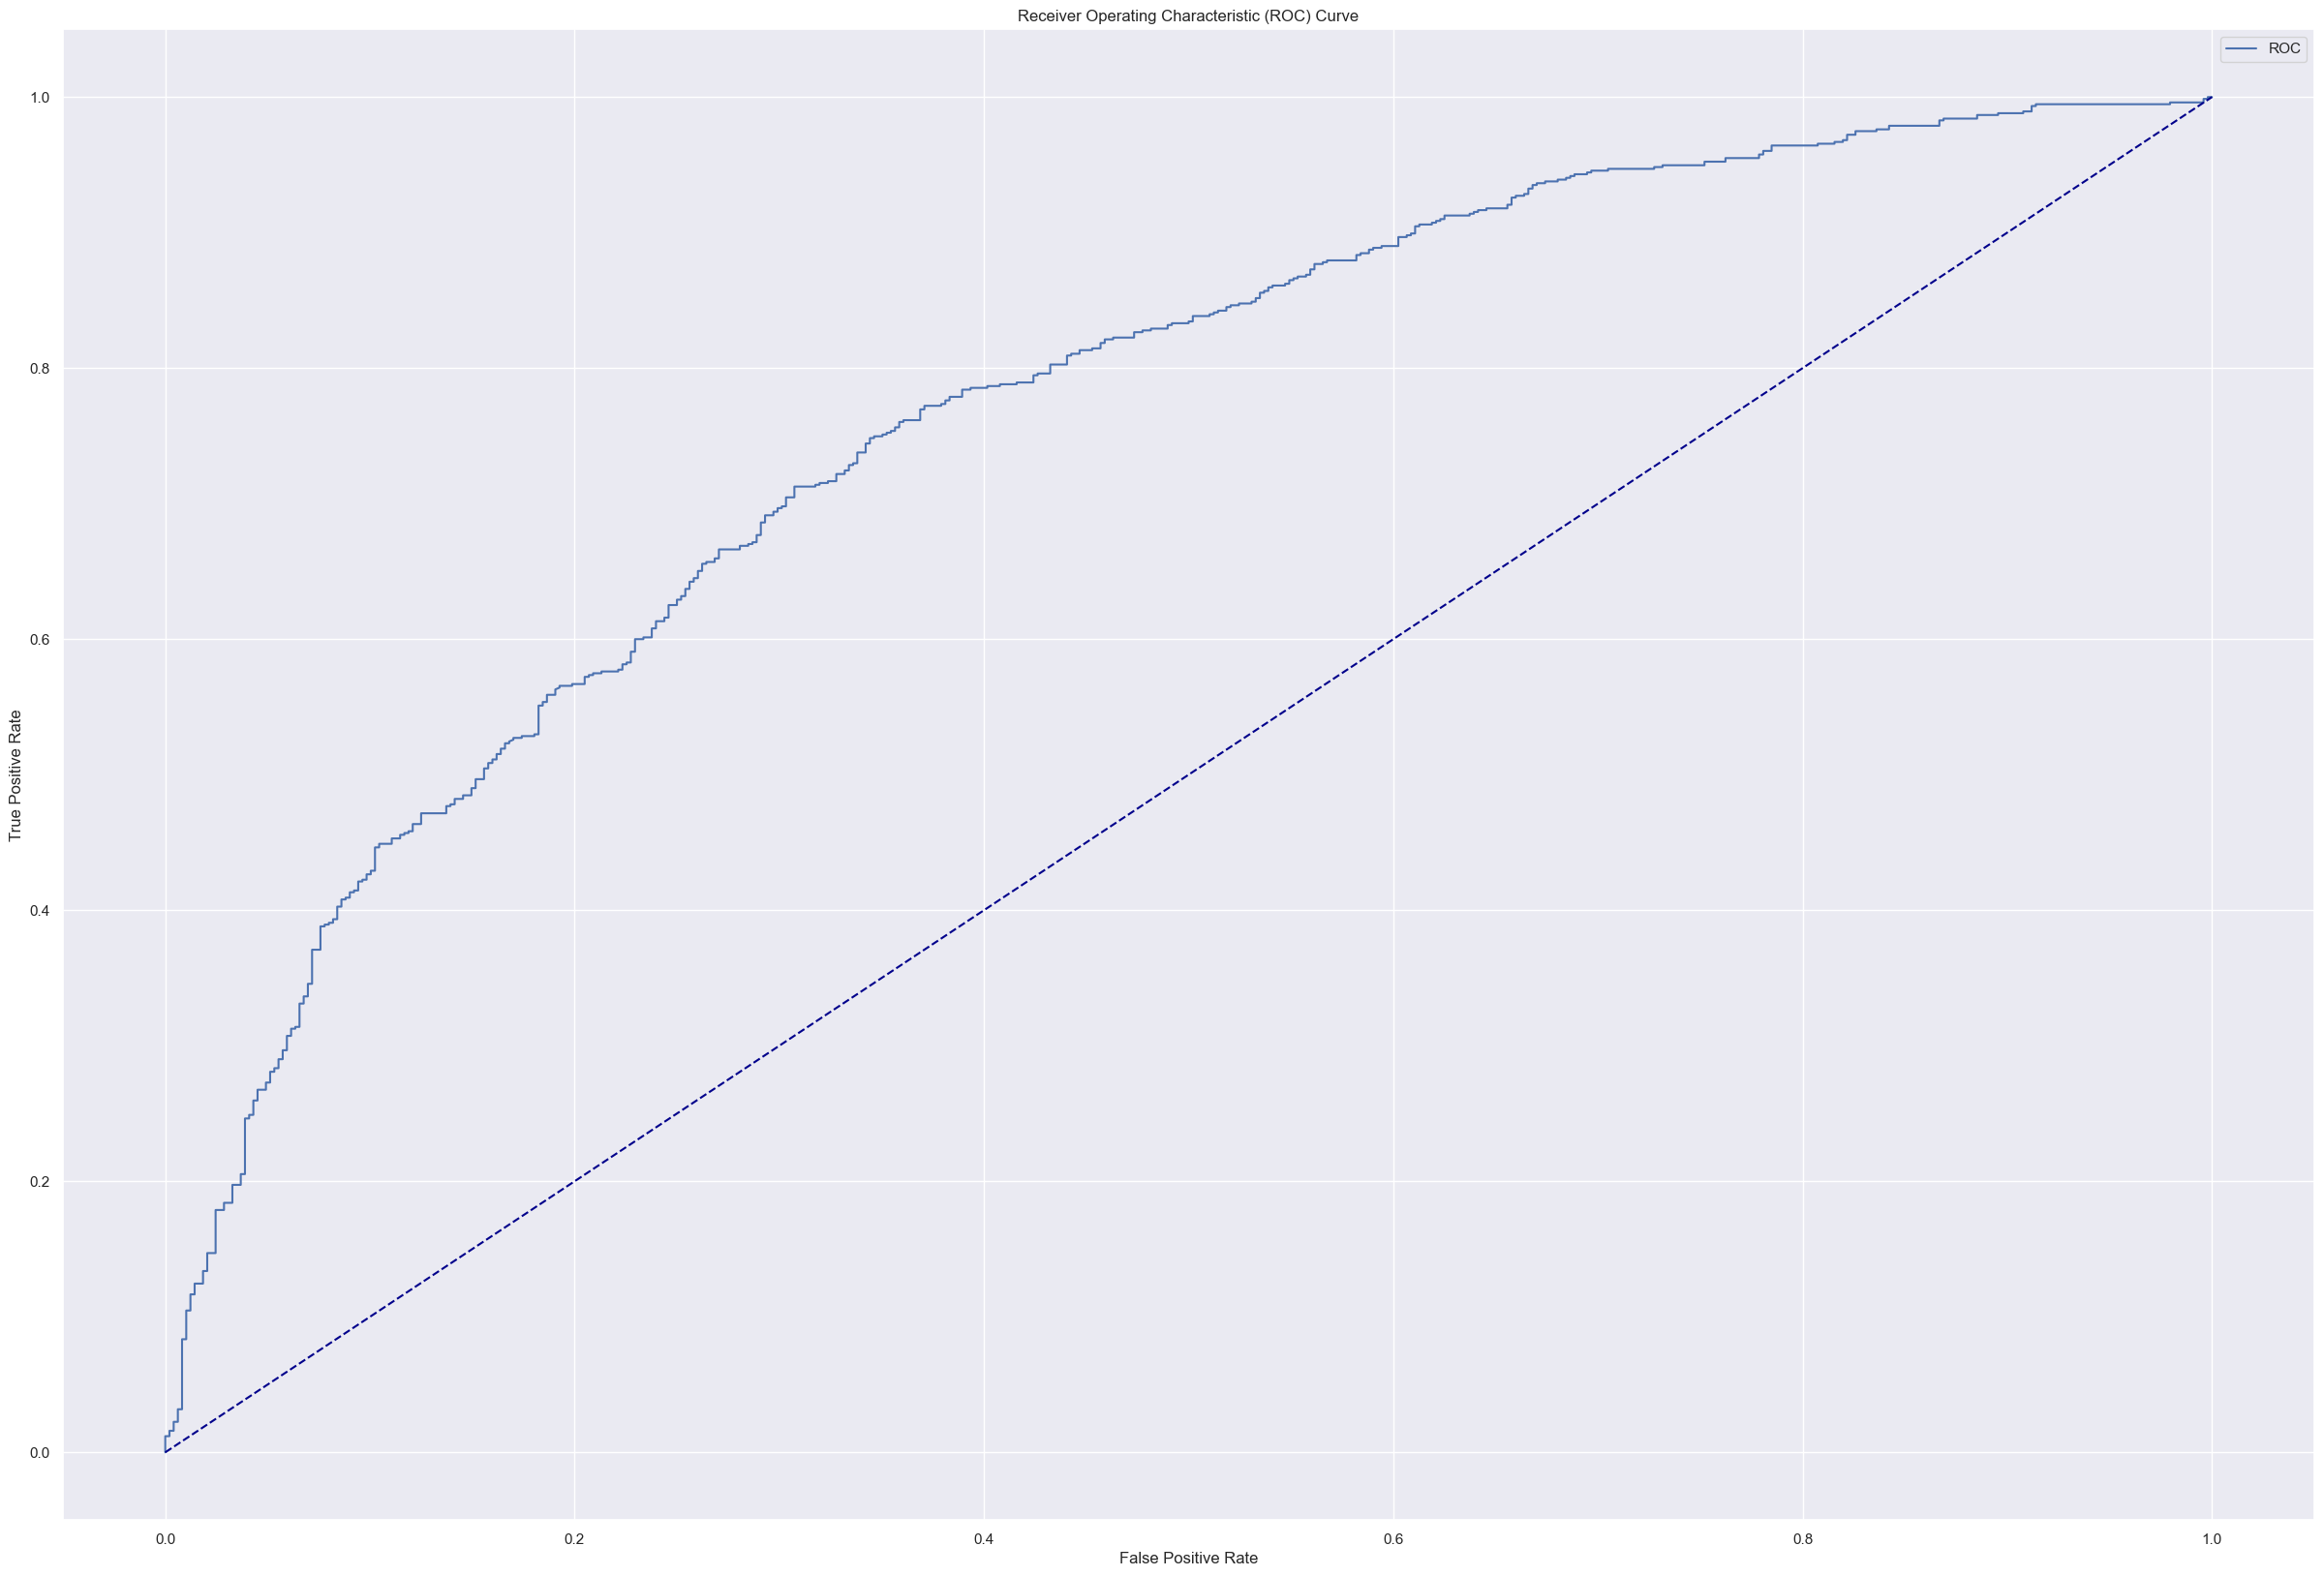

AUC: 0.76


In [97]:
model_Ada=AdaBoostClassifier(n_estimators=100, learning_rate=0.5)

fpr7,tpr7=roc(model_Ada,X_train,y_train,X_test,y_test)

### RF

In [98]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
param_RF = {'criterion': ['entropy','gini'],
              'n_estimators' : [50,100,200,1000],
              'max_depth': [1,5,6,7,10]}

hyperp_search(RF,param_RF)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
f1_train: 0.808913 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 1000} in 49.994 seconds
           train    test 
f1         0.917    0.807
precision  0.864    0.747

[[264 224]
 [ 93 662]]
              precision    recall  f1-score   support

       False       0.74      0.54      0.62       488
        True       0.75      0.88      0.81       755

    accuracy                           0.74      1243
   macro avg       0.74      0.71      0.72      1243
weighted avg       0.74      0.74      0.74      1243



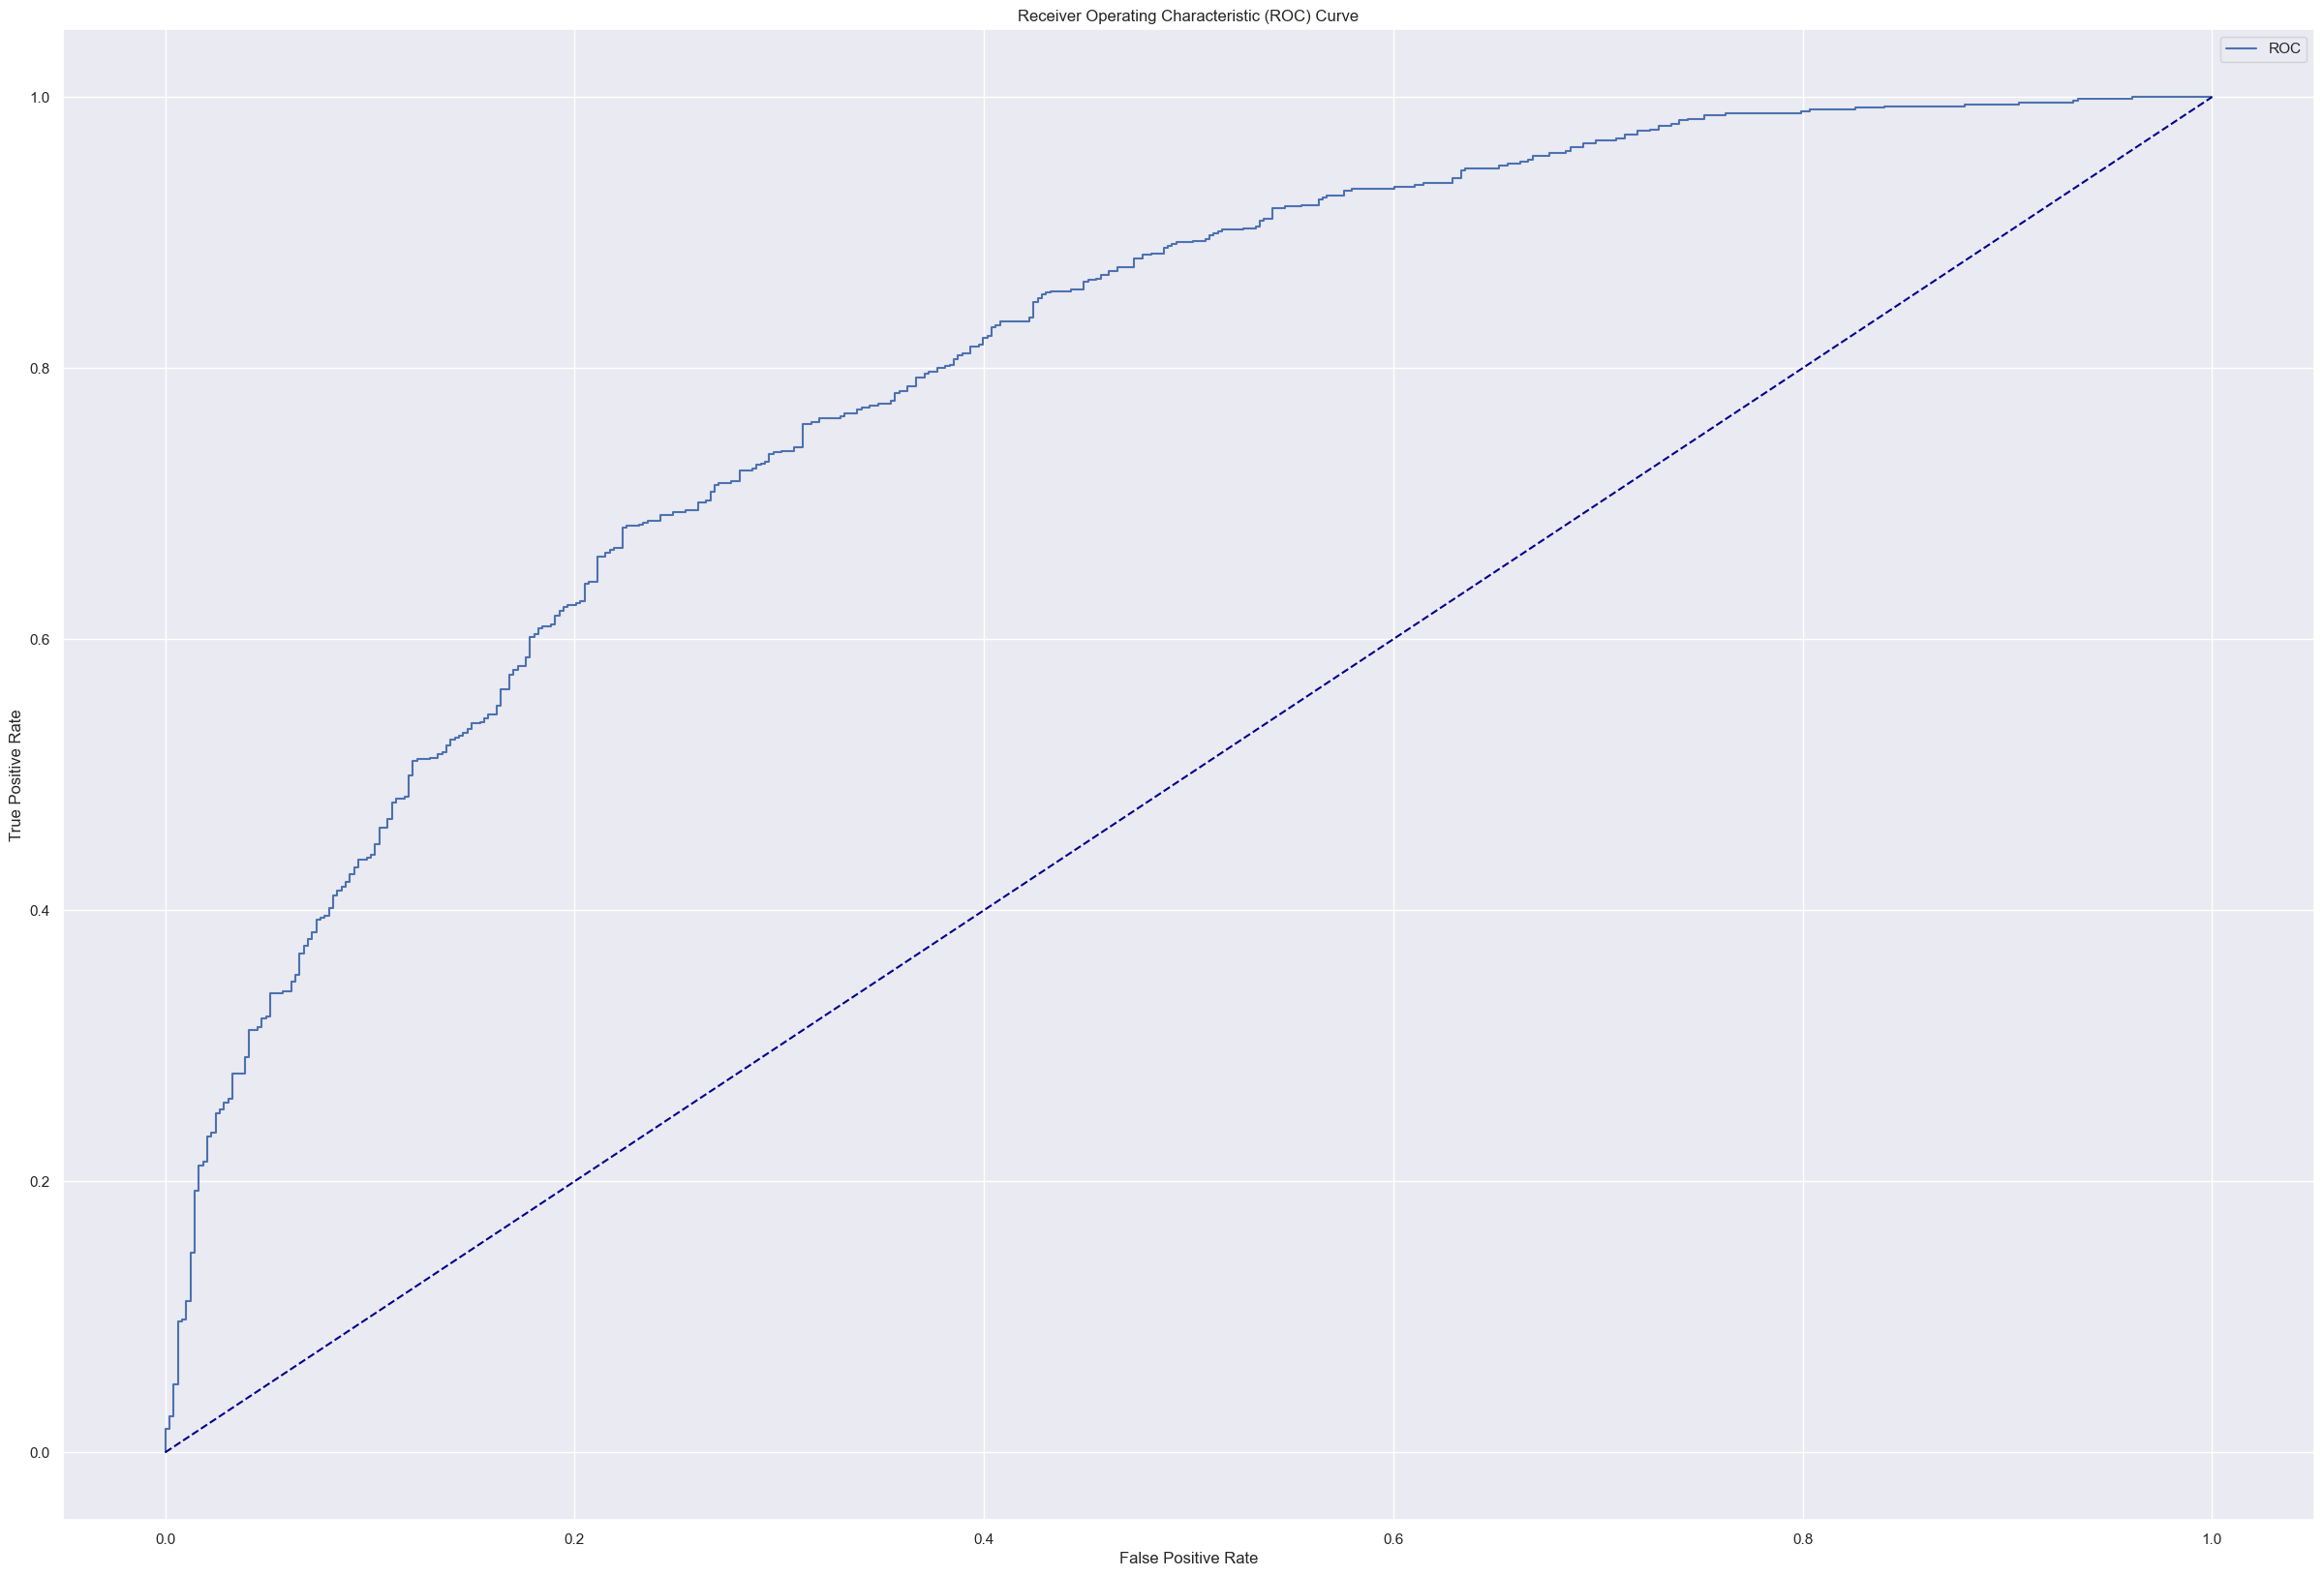

AUC: 0.80


In [99]:
model_RF=RandomForestClassifier(n_estimators=1000,criterion='gini', max_depth=10)

fpr8,tpr8=roc(model_RF,X_train,y_train,X_test,y_test)

<AxesSubplot:>

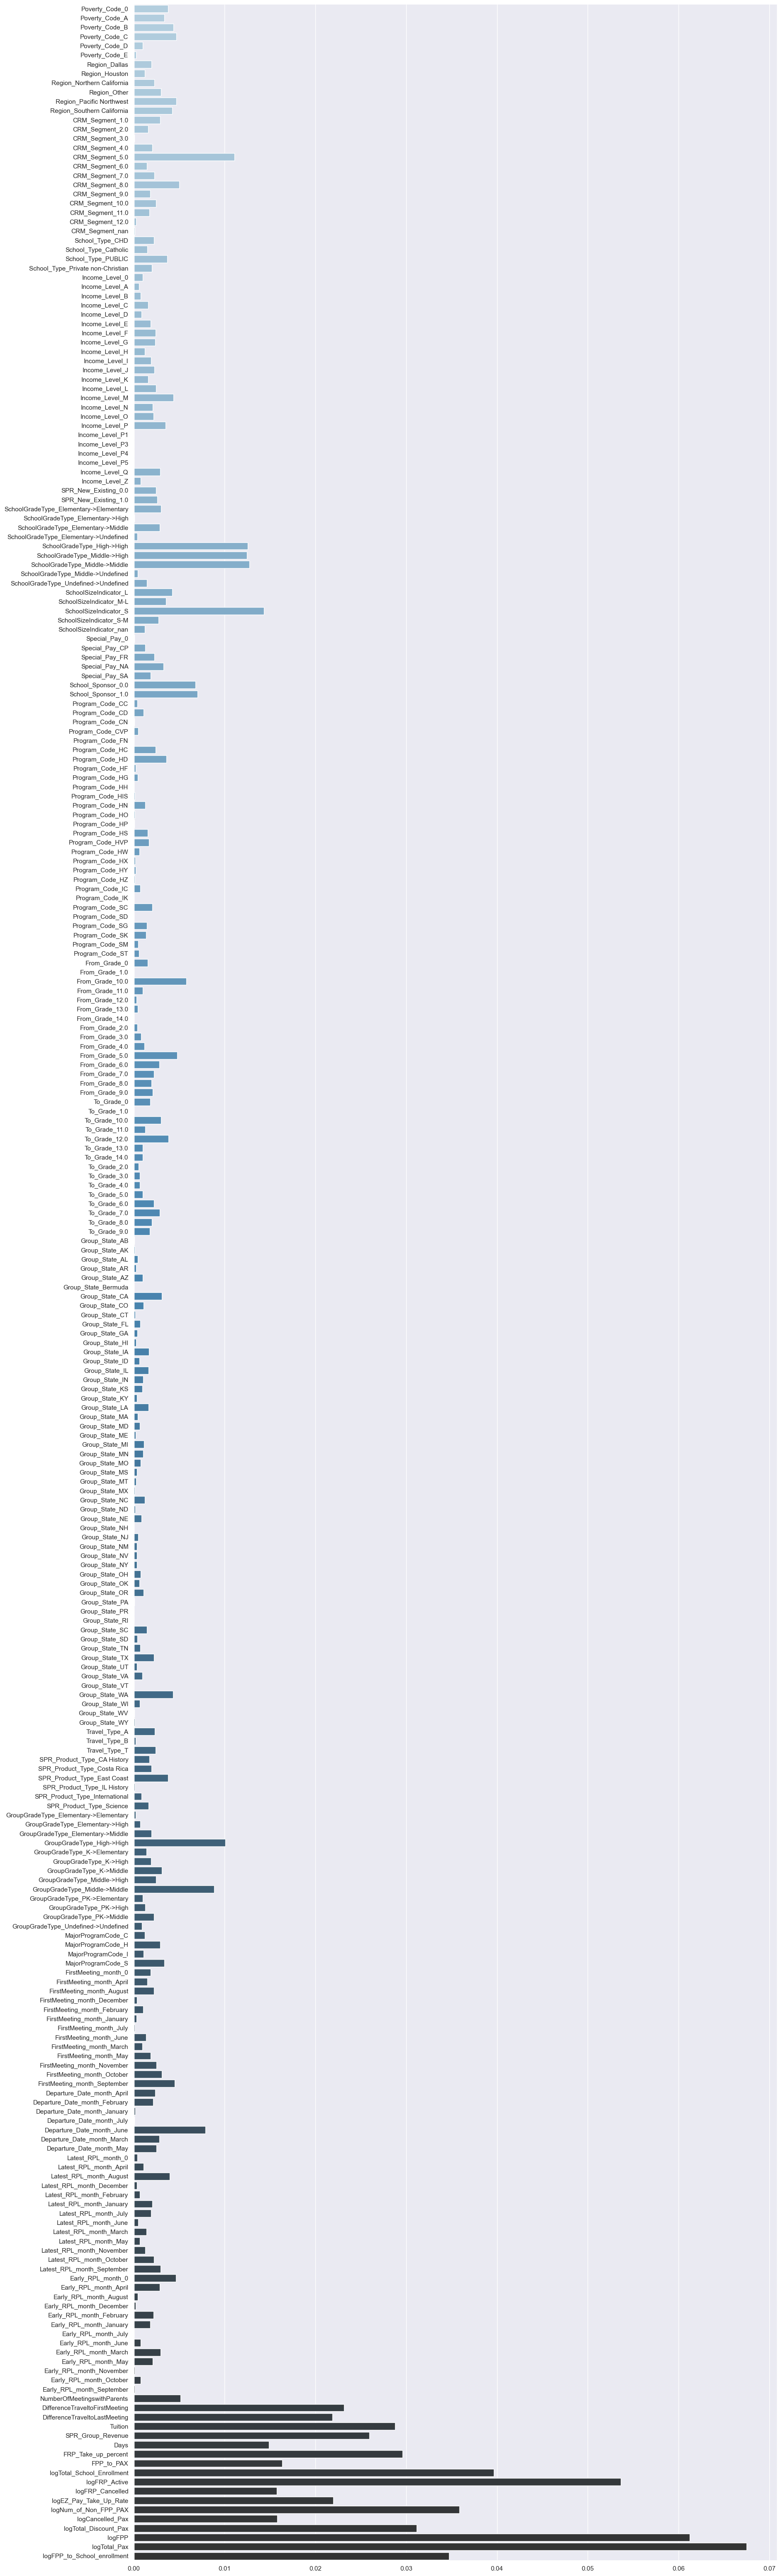

In [100]:
sns.set(rc={'figure.figsize':(20,80)})
sns.barplot(y=X_train.columns, x=model_RF.feature_importances_, palette="Blues_d", orient="h")

Important features
1. logTotal_Pax
2. logFPP
3. logFRP_Active
4. logTotal_School_Enrollment
5. logNum_of_Non_FPP_PAX

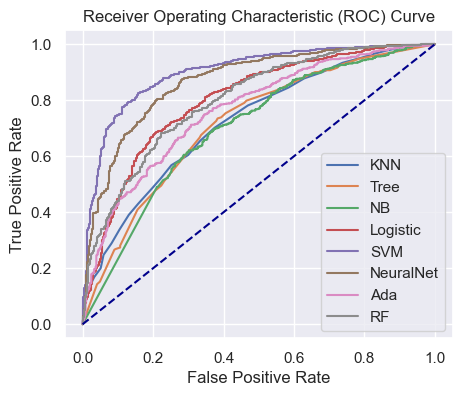

In [101]:
sns.set(rc={'figure.figsize':(5,4)})
plt.plot(fpr1, tpr1, label= "KNN")
plt.plot(fpr2, tpr2, label= "Tree")
plt.plot(fpr3, tpr3, label= "NB")
plt.plot(fpr4, tpr4, label= "Logistic")    
plt.plot(fpr5, tpr5, label= "SVM")
plt.plot(fpr6, tpr6, label= "NeuralNet")
plt.plot(fpr7, tpr7, label= "Ada")
plt.plot(fpr8, tpr8, label= "RF")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Save the model

In [102]:
import pickle

In [103]:
pickle.dump(model_RF, open('RF_model.pkl', 'wb'))

## Making predictions

In [104]:
import pickle
import pandas as pd
import numpy as np
import math
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [105]:
# load encoder, scaler and model
loaded_encoder = pickle.load(open('encoder.pkl', 'rb'))
loaded_scaler = pickle.load(open('scaler.pkl', 'rb'))
loaded_model = pickle.load(open('RF_model.pkl', 'rb'))

### Import new data

In [106]:
#save new data
df_crm_new = pd.read_csv('crm_test.csv', parse_dates=['FirstMeeting','LastMeeting'],
                      infer_datetime_format=True)
df_finance_new = pd.read_csv('finance_test.csv', keep_default_na=False, parse_dates=['Deposit_Date'],
                      infer_datetime_format=True)
df_sales_new = pd.read_csv('sales_test.csv', parse_dates=['Departure_Date','Return_Date','Early_RPL','Latest_RPL','Initial_System_Date'],
                      infer_datetime_format=True)

In [107]:
# check for duplicates in ID_CRM
duplicates_crm = df_crm_new['ID_CRM'].duplicated()
if duplicates_crm.any():
    print("Found duplicates in ID_CRM column:")
    print(df_crm[duplicates_crm])

In [108]:
# check for duplicates in ID_FINANCE
duplicates_finance = df_finance_new['ID_FINANCE'].duplicated()
if duplicates_finance.any():
    print("Found duplicates in ID_FINANCE column:")
    print(df_finance[duplicates_finance])

In [109]:
# check for duplicates in ID_SALES
duplicates_sales = df_sales_new['ID_SALES'].duplicated()
if duplicates_sales.any():
    print("Found duplicates in ID_SALES column:")
    print(df_sales[duplicates_sales])

In [110]:
import re

# define a function to remove the last digit and any alphabets in the ID_CRM column
def clean_id_crm(ID_CRM):
    # Remove the last digit
    ID_CRM = ID_CRM[:-1]
    
    # Remove any alphabets
    ID_CRM = re.sub('[^0-9]+', '', ID_CRM)
    
    return ID_CRM

# apply the function to the ID_CRM column
df_crm_new['ID_CRM'] = df_crm_new['ID_CRM'].apply(clean_id_crm)

print(df_crm_new)

    ID_CRM Poverty_Code               Region  CRM_Segment  \
0    01005            0  Southern California          4.0   
1    01040            0                Other          5.0   
2    01096            0                Other          7.0   
3    01108            0                Other         11.0   
4    01114            0  Southern California          4.0   
..     ...          ...                  ...          ...   
625   1496            E  Northern California          4.0   
626   2478            E                Other          2.0   
627     27            E                Other          5.0   
628   2884            E                Other          9.0   
629   4473            E  Northern California          5.0   

               School_Type  Parent_Meeting_Flag MDR_Low_Grade  MDR_High_Grade  \
0                      CHD                    0            PK             6.0   
1                      CHD                    1             6            12.0   
2                   PUBL

In [111]:
# define a function to remove alphabets from the 'ID_FINANCE' column
def remove_alpha(s):
    return ''.join([i for i in s if not i.isalpha()])

# apply the function to the id_finance column
df_finance_new['ID_FINANCE'] = df_finance_new['ID_FINANCE'].apply(remove_alpha)

print(df_finance_new)

    ID_FINANCE Deposit_Date Special_Pay  Tuition  FRP_Active  FRP_Cancelled  \
0         1005   2018-11-20          CP      424          14              4   
1         1040   2018-05-22          CP     2008          32              0   
2         1261   2018-10-20          CP     1699          28              3   
3         1480   2018-10-11          CP     2010          17              2   
4         1939   2018-10-03          CP     2078           6              0   
..         ...          ...         ...      ...         ...            ...   
625       4600   2018-06-09          SA      656           0              0   
626       4807   2018-09-26          SA     1415           0              0   
627       4876   2018-10-23          SA      754           0              0   
628        702   2018-05-31          SA      960           0              0   
629        773   2018-10-27          SA      154           0              0   

     FRP_Take_up_percent_  EZ_Pay_Take_Up_Rate  Sch

In [112]:
# define a function to remove alphabets and 0 from the 'ID_SALES' column

def remove_alpha(s):
    s = ''.join([i for i in s if not i.isalpha()])
    if len(s) > 4 and s[-1] == '0':
        s = s[:-1]
    return s

# apply the function to the 'ID_SALES' column
df_sales_new['ID_SALES'] = df_sales_new['ID_SALES'].apply(remove_alpha)

print(df_sales_new)

    ID_SALES Program_Code  From_Grade  To_Grade Group_State  Days Travel_Type  \
0       1040           CC         7.0       7.0          AZ    25           A   
1       1525           CC        10.0      10.0          CA    22           A   
2       2011           CC         8.0      10.0          TX     9           A   
3       1132           CD         9.0       9.0          CA    20           A   
4       1178           CD         6.0       6.0          TN    16           T   
..       ...          ...         ...       ...         ...   ...         ...   
625     2761           ST         7.0       8.0          CA    13           A   
626     3672           ST         7.0       8.0          TX    12           A   
627      372           ST         6.0       8.0          CA    24           A   
628      455           ST         4.0       6.0          TX     9           A   
629     4821           ST         5.0       7.0          OK    13           A   

    Departure_Date Return_D

In [113]:
# change data type to integer
df_crm_new['ID_CRM'] = df_crm_new['ID_CRM'].astype(int)
df_finance_new['ID_FINANCE'] = df_finance_new['ID_FINANCE'].astype(int)
df_sales_new['ID_SALES'] = df_sales_new['ID_SALES'].astype(int)

In [114]:
# Rename the ID columns to a common name
df_crm_new = df_crm_new.rename(columns={'ID_CRM': 'ID'})
df_finance_new = df_finance_new.rename(columns={'ID_FINANCE': 'ID'})
df_sales_new = df_sales_new.rename(columns={'ID_SALES': 'ID'})

# Merge the dataframes on the common ID column
df_new = pd.merge(df_crm_new, df_finance_new, on='ID', how='outer')
df_new = pd.merge(df_new, df_sales_new, on='ID', how='outer')

# drop blank column
df_new=df_new.iloc[:, :-1]

# display the merged dataframe
print(df_new.head())

     ID Poverty_Code               Region  CRM_Segment            School_Type  \
0  1005            0  Southern California          4.0                    CHD   
1  1040            0                Other          5.0                    CHD   
2  1096            0                Other          7.0                 PUBLIC   
3  1108            0                Other         11.0               Catholic   
4  1114            0  Southern California          4.0  Private non-Christian   

   Parent_Meeting_Flag MDR_Low_Grade  MDR_High_Grade  Total_School_Enrollment  \
0                    0            PK             6.0                      315   
1                    1             6            12.0                      541   
2                    1             0             NaN                        0   
3                    1            PK             8.0                      351   
4                    1            PK             6.0                       82   

  Income_Level  ...  Initi

### Cleaning new data

In [115]:
# Change data type
df_new['ID'] = df_new['ID'].astype('string')
df_new['Region'] = df_new['Region'].astype('string')
df_new['CRM_Segment'] = df_new['CRM_Segment'].astype('object')
df_new['MDR_High_Grade'] = df_new['MDR_High_Grade'].astype('object')
df_new['School_Type'] = df_new['School_Type'].astype('string')
df_new['Parent_Meeting_Flag'] = df_new['Parent_Meeting_Flag'].astype(str)
df_new['Income_Level'] = df_new['Income_Level'].astype('string')
df_new['SPR_New_Existing'] = df_new['SPR_New_Existing'].astype(str)
df_new['SchoolGradeTypeLow'] = df_new['SchoolGradeTypeLow'].astype('string')
df_new['SchoolGradeTypeHigh'] = df_new['SchoolGradeTypeHigh'].astype('string')
df_new['SchoolGradeType'] = df_new['SchoolGradeType'].astype('string')
df_new['SchoolSizeIndicator'] = df_new['SchoolSizeIndicator'].astype(str)
df_new['School_Sponsor'] = df_new['School_Sponsor'].astype(str)
df_new['Program_Code'] = df_new['Program_Code'].astype('string')
df_new['From_Grade'] = df_new['From_Grade'].astype('string')
df_new['To_Grade'] = df_new['To_Grade'].astype('string')
df_new['Group_State'] = df_new['Group_State'].astype('string')
df_new['Travel_Type'] = df_new['Travel_Type'].astype('string')
df_new['SPR_Product_Type'] = df_new['SPR_Product_Type'].astype('string')
df_new['GroupGradeTypeLow'] = df_new['GroupGradeTypeLow'].astype('string')
df_new['GroupGradeTypeHigh'] = df_new['GroupGradeTypeHigh'].astype('string')
df_new['MajorProgramCode'] = df_new['MajorProgramCode'].astype('string')

In [116]:
# Extract the day, month, and year components of each date column

for col in ['FirstMeeting', 'LastMeeting','Deposit_Date','Departure_Date','Return_Date','Latest_RPL','Early_RPL','Initial_System_Date']:
    df_new[f'{col}_date'] = df_new[col].dt.strftime('%d')
    df_new[f'{col}_month'] = df_new[col].dt.strftime('%B')
    df_new[f'{col}_year'] = df_new[col].dt.strftime('%Y')

# Drop DepartureMonth to avoid duplicate
df_new=df_new.drop('DepartureMonth', axis=1) 

In [117]:
# Replace Null in Date features as 0/0/2000

fill_values = {'FirstMeeting_date': '0', 'FirstMeeting_month': '0',
              'FirstMeeting_year': '2000','LastMeeting_date': '0','LastMeeting_month': '0','LastMeeting_year': '2000',
               'Early_RPL_date':'0','Early_RPL_month':'0','Early_RPL_year':'2000','Latest_RPL_date': '0',
               'Latest_RPL_month': '0','Latest_RPL_year': '2000',
               'Initial_System_Date_date':'0','Initial_System_Date_month':'0','Initial_System_Date_year':'2000'}

df_new = df_new.fillna(value=fill_values)

In [118]:
# Remove negative value on DifferenceTraveltoLastMeeting
df_new.drop(df_new[df_new['DifferenceTraveltoLastMeeting'] < 0].index, inplace=True)

# Fill in DifferenceTraveltoFirstMeeting & DifferenceTraveltoLastMeeting as 0 as the meeting did not occur
df_new['DifferenceTraveltoFirstMeeting'].fillna(0, inplace=True)
df_new['DifferenceTraveltoLastMeeting'].fillna(0, inplace=True)

# Check for NULL values
null_values_diff = df_new['DifferenceTraveltoLastMeeting'].isnull().sum()

# Print the null values for each column
print(null_values_diff)

0


In [119]:
# Drop and Recalculate FRP_Take_up_percent_ for accuracy
df_new=df_new.drop('FRP_Take_up_percent_', axis=1)

df_new['FRP_Take_up_percent']=(df_new['FRP_Active']-df_new['FRP_Cancelled']).div(df_new['FPP'])

print(df_new['FRP_Take_up_percent'].head())

0    0.476190
1    0.533333
2    0.400000
3    0.160000
4    0.444444
Name: FRP_Take_up_percent, dtype: float64


In [120]:
# Drop and Recalculate FPP_to_PAX for accuracy

df_new=df_new.drop('FPP_to_PAX', axis=1)

df_new['FPP_to_PAX']=df_new['FPP'].div(df_new['Total_Pax'])
print(df_new['FPP_to_PAX'].head())


0    0.807692
1    1.000000
2    1.057692
3    1.000000
4    0.900000
Name: FPP_to_PAX, dtype: float64


In [121]:
# Drop and Recalculate FPP_to_School_enrollment for accuracy

df_new=df_new.drop('FPP_to_School_enrollment', axis=1)

df_new['FPP_to_School_enrollment']=df_new['FPP'].div(df_new['Total_School_Enrollment'])
df_new['FPP_to_School_enrollment'] = df_new['FPP_to_School_enrollment'].replace([np.inf, -np.inf], 1)
print(df_new['FPP_to_School_enrollment'].head())


0    0.066667
1    0.110906
2    1.000000
3    0.071225
4    0.439024
Name: FPP_to_School_enrollment, dtype: float64


In [122]:
null_FPP_to_School_enrollment=df_new['FPP_to_School_enrollment'].isnull().sum()
print(null_FPP_to_School_enrollment)

0


In [123]:
df_new

ID Poverty_Code               Region CRM_Segment  \
0    1005            0  Southern California         4.0   
1    1040            0                Other         5.0   
2    1096            0                Other         7.0   
3    1108            0                Other        11.0   
4    1114            0  Southern California         4.0   
..    ...          ...                  ...         ...   
625  1496            E  Northern California         4.0   
626  2478            E                Other         2.0   
627    27            E                Other         5.0   
628  2884            E                Other         9.0   
629  4473            E  Northern California         5.0   

               School_Type Parent_Meeting_Flag MDR_Low_Grade MDR_High_Grade  \
0                      CHD                   0            PK            6.0   
1                      CHD                   1             6           12.0   
2                   PUBLIC                   1             0            NaN   
3                 Catholic                   1            PK            8.0   
4    Private non-Christian                   1            PK            6.0   
..                     ...                 ...           ...            ...   
625                 PUBLIC                   1             K            6.0   
626                 PUBLIC                   1             6            8.0   
627                 PUBLIC                   1             6            8.0   
628                 PUBLIC                   1             9           12.0   
629                 PUBLIC                   1             6            8.0   

     Total_School_Enrollment Income_Level  ... Latest_RPL_year  \
0                        315            P  ...            2018   
1                        541            K  ...            2018   
2                          0            0  ...            2018   
3                        351            I  ...            2018   
4                         82            Q  ...            2018   
..                       ...          ...  ...             ...   
625                      461            J  ...            2018   
626                      444            C  ...            2018   
627                      581            M  ...            2018   
628                      963            O  ...            2018   
629                      637            J  ...            2018   

     Early_RPL_date Early_RPL_month Early_RPL_year  Initial_System_Date_date  \
0                06             May           2018                        15   
1                27        February           2018                        26   
2                28        February           2018                        27   
3                06             May           2018                        06   
4                 0               0           2000                        20   
..              ...             ...            ...                       ...   
625              14           April           2018                        14   
626               0               0           2000                        23   
627              08           March           2018                        07   
628              09             May           2018                        30   
629               0               0           2000                        04   

     Initial_System_Date_month Initial_System_Date_year FRP_Take_up_percent  \
0                          May                     2018            0.476190   
1                      January                     2018            0.533333   
2                        March                     2018            0.400000   
3                        April                     2018            0.160000   
4                    September                     2018            0.444444   
..                         ...                      ...                 ...   
625                      April            

### Scaling

In [124]:
df_new_cat=df_new.select_dtypes(include=['string','object','category'])

# Categorical
selection_cat=['Poverty_Code','Region', 'CRM_Segment', 'School_Type','Income_Level', 'SPR_New_Existing',
               'SchoolGradeType', 'SchoolSizeIndicator', 'Special_Pay', 'School_Sponsor','Program_Code',
               'From_Grade','To_Grade','Group_State','Travel_Type','SPR_Product_Type','GroupGradeType','MajorProgramCode',
               'FirstMeeting_month','Departure_Date_month','Latest_RPL_month','Early_RPL_month']
dummies_new = loaded_encoder.transform(df_new[selection_cat]).toarray() #encoded the data

columns_dummies=encoder.get_feature_names_out()
dummies_new =pd.DataFrame(dummies_new,columns=columns_dummies)

# Numerical
df_new_num=df_new.select_dtypes(include=[np.number])

df_new_num['logTotal_School_Enrollment']=df_new_num['Total_School_Enrollment'].apply(lambda x: math.log(x+1))
df_new_num['logFRP_Active']=df_new_num['FRP_Active'].apply(lambda x: math.log(x+1)) 
df_new_num['logFRP_Cancelled']=df_new_num['FRP_Cancelled'].apply(lambda x: math.log(x+1))
df_new_num['logEZ_Pay_Take_Up_Rate']=df_new_num['EZ_Pay_Take_Up_Rate'].apply(lambda x: math.log(x+1))
df_new_num['logNum_of_Non_FPP_PAX']=df_new_num['Num_of_Non_FPP_PAX'].apply(lambda x: math.log(x+1))
df_new_num['logCancelled_Pax']=df_new_num['Cancelled_Pax'].apply(lambda x: math.log(x+1))
df_new_num['logTotal_Discount_Pax']=df_new_num['Total_Discount_Pax'].apply(lambda x: math.log(x+1))
df_new_num['logFPP']=df_new_num['FPP'].apply(lambda x: math.log(x+1))
df_new_num['logTotal_Pax']=df_new_num['Total_Pax'].apply(lambda x: math.log(x+1))
df_new_num['logFPP_to_School_enrollment']=df_new_num['FPP_to_School_enrollment'].apply(lambda x: math.log(x+1))

selection_num=['NumberOfMeetingswithParents', 'DifferenceTraveltoFirstMeeting',
       'DifferenceTraveltoLastMeeting', 'Tuition', 'SPR_Group_Revenue', 'Days',
       'FRP_Take_up_percent', 'FPP_to_PAX', 'logTotal_School_Enrollment',
       'logFRP_Active', 'logFRP_Cancelled', 'logEZ_Pay_Take_Up_Rate',
       'logNum_of_Non_FPP_PAX', 'logCancelled_Pax', 'logTotal_Discount_Pax',
       'logFPP', 'logTotal_Pax','logFPP_to_School_enrollment']
df_new_selection_num=df_new_num[selection_num]
scaled_df_new = pd.DataFrame(loaded_scaler.transform(df_new_selection_num))
scaled_df_new.columns = df_new_selection_num.columns

X2=pd.concat([dummies_new,scaled_df_new], axis = 1)


In [125]:
null=X2.isnull().sum()
print(null)

Poverty_Code_0                 0
Poverty_Code_A                 0
Poverty_Code_B                 0
Poverty_Code_C                 0
Poverty_Code_D                 0
                              ..
logCancelled_Pax               0
logTotal_Discount_Pax          0
logFPP                         0
logTotal_Pax                   0
logFPP_to_School_enrollment    0
Length: 276, dtype: int64


In [126]:
X2

Poverty_Code_0  Poverty_Code_A  Poverty_Code_B  Poverty_Code_C  \
0               1.0             0.0             0.0             0.0   
1               1.0             0.0             0.0             0.0   
2               1.0             0.0             0.0             0.0   
3               1.0             0.0             0.0             0.0   
4               1.0             0.0             0.0             0.0   
..              ...             ...             ...             ...   
623             0.0             0.0             0.0             0.0   
624             0.0             0.0             0.0             0.0   
625             0.0             0.0             0.0             0.0   
626             0.0             0.0             0.0             0.0   
627             0.0             0.0             0.0             0.0   

     Poverty_Code_D  Poverty_Code_E  Region_Dallas  Region_Houston  \
0               0.0             0.0            0.0             0.0   
1               0.0             0.0            0.0             0.0   
2               0.0             0.0            0.0             0.0   
3               0.0             0.0            0.0             0.0   
4               0.0             0.0            0.0             0.0   
..              ...             ...            ...             ...   
623             0.0             1.0            0.0             0.0   
624             0.0             1.0            0.0             0.0   
625             0.0             1.0            0.0             0.0   
626             0.0             1.0            0.0             0.0   
627             0.0             1.0            0.0             0.0   

     Region_Northern California  Region_Other  ...  \
0                           0.0           0.0  ...   
1                           0.0           1.0  ...   
2                           0.0           1.0  ...   
3                           0.0           1.0  ...   
4                           0.0           0.0  ...   
..                          ...           ...  ...   
623                         1.0           0.0  ...   
624                         0.0           1.0  ...   
625                         0.0           1.0  ...   
626                         0.0           1.0  ...   
627                         1.0           0.0  ...   

     logTotal_School_Enrollment  logFRP_Active  logFRP_Cancelled  \
0                     -0.196842       0.230158          0.553056   
1                      0.187246       1.028308         -1.511664   
2                     -4.294364       0.705939         -0.622438   
3                     -0.120036      -0.541352         -0.102274   
4                     -1.148584       0.414721         -0.622438   
..                          ...            ...               ...   
623                    0.073554       0.705939          1.307117   
624                    0.046865       1.468978          1.564554   
625                    0.237936      -0.881961         -0.102274   
626                    0.597177      -1.809516         -1.511664   
627                    0.303337      -0.697398         -1.511664   

     logEZ_Pay_Take_Up_Rate  logNum_of_Non_FPP_PAX  logCancelled_Pax  \
0                 -1.111589              -1.006090         -0.134196   
1                  0.455668               0.748049         -1.915320   
2                  0.166302               0.748049         -1.024758   
3                  2.241882              -0.229871         -1.024758   
4                 -0.610124              -1.006090          0.386749   
..                      ...                    ...               ...   
623                0.263090               0.748049          1.724818   
624                0.206848               0.748049          1.043062   
625                2.054925              -1.006090         -0.503813   
626               -0.983521               0.748049          0.756366   
627                1.247462              -1.006090   

### Deploy model

In [137]:
y_RF_predictions = loaded_model.predict(X2)

In [138]:
# Retention probabilities
y_RF_prob = loaded_model.predict_proba(X2)[:,1]
print(y_RF_prob)

[0.73320058 0.86642619 0.78247191 0.63025115 0.71256103 0.56373236
 0.59537109 0.48824911 0.81541327 0.54484382 0.76355614 0.70698331
 0.8195109  0.51475443 0.48884535 0.47723349 0.70696734 0.5408112
 0.49387828 0.79826328 0.7340643  0.37950938 0.80848072 0.62150678
 0.55685455 0.78598502 0.77964598 0.72884688 0.45604916 0.58043613
 0.44350102 0.3846585  0.5185387  0.8132749  0.76452089 0.65189606
 0.64858169 0.83409319 0.48959696 0.5728756  0.54126916 0.47184159
 0.81339545 0.43985376 0.51653195 0.76756504 0.41966782 0.31795799
 0.36607764 0.79228324 0.70381431 0.37388065 0.52156879 0.65114843
 0.68260547 0.82613943 0.532153   0.90415799 0.83184173 0.59804799
 0.77118314 0.45266743 0.40133818 0.65951284 0.36179111 0.82911685
 0.31249009 0.44057104 0.62781417 0.88535029 0.51150797 0.5716631
 0.3037447  0.63669979 0.73369624 0.61081134 0.54822687 0.630349
 0.77566322 0.78891675 0.75508925 0.62187567 0.66065418 0.52727822
 0.67787225 0.3987661  0.57099689 0.60898337 0.56023347 0.48141615

In [143]:
# Retention probability overall
churn_prob=y_RF_prob.mean()
print('Average Retention probability:',churn_prob)

Average Retention probability: 0.6224948935063227


On average, the model predicts that there is a 62.18% chance that a customer will churn.

In [140]:
# Print the result
y_RF_predictions

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True, False,  True,
        True, False, False, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True, False,  True, False, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True, False,  True,  True,  True, False,  True, False, False,
       False,  True, False, False,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,

In [141]:
import numpy as np

true_count = np.count_nonzero(y_RF_predictions)
false_count = len(y_RF_predictions) - true_count

print("True count:", true_count)
print("False count:", false_count)


True count: 468
False count: 160


In [142]:
# Convert NumPy array to pandas DataFrame
df_pred = pd.DataFrame({'Predictions': y_RF_predictions.astype(int)})

# Export DataFrame to CSV file
df_pred.to_csv('Kowit.csv', index=False)